## Installing Libraries

In [1]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install fastai=='1.0.60'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install torch=='1.1.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.1.0 (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.1.0


# Importing Libraries

In [4]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [5]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.60', '2.0.0+cu118')

# Fetching Training and Validation Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Fetching Training Data

In [ ]:
path_train_dataset = '/content/drive/My Drive/gujarati-news-dataset/train.csv'
train_df = pd.read_csv(path_train_dataset)
train_df.head()

In [ ]:
print('In Training data:')
for category in train_df['label'].unique():
  print(category, (train_df['label'] == category).sum())

### Fetching Validation Data

In [ ]:
path_valid_dataset = '/content/drive/My Drive/gujarati-news-dataset/valid.csv'
valid_df = pd.read_csv(path_valid_dataset)
valid_df.head()

In [ ]:
print('In Validation data:')
for category in valid_df['label'].unique():
  print(category, (valid_df['label'] == category).sum())

# Building Gujarati Language Model

In [ ]:
label_cols = list(range(1,train_df.shape[1]))

In [ ]:
id_to_col = list(train_df.columns)

In [ ]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [ ]:
class GujaratiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str("/content/drive/My Drive/NLP Gujarati/gujarati_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load(str("/content/drive/My Drive/NLP Gujarati/gujarati_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(20000)]

In [ ]:
itos[:10]

In [ ]:
gujarati_vocab = Vocab(itos)

In [ ]:
tokenizer = Tokenizer(tok_func=GujaratiTokenizer, lang='gu')

In [ ]:
tokenizer.special_cases

In [ ]:
data_lm = TextLMDataBunch.from_df(path="/content/drive/My Drive/NLP Gujarati/", train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=gujarati_vocab, bs=16)

In [ ]:
data_lm.save()

In [ ]:
data_lm.show_batch()

# Training Classifier Model

In [ ]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [ ]:
learn.load('/content/drive/My Drive/NLP Gujarati/third_gu_lm', with_opt=True)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

In [ ]:
learn.predict('શાહરૂખ ખાન સાથે',n_words=10)

In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
data_clas = TextClasDataBunch.from_df(path="/content/drive/My Drive/NLP Gujarati/", train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=gujarati_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [ ]:
data_clas.show_batch()

In [ ]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [ ]:
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.loss_func.func

In [ ]:
kappa = KappaScore()

In [ ]:
learn.metrics = [kappa, accuracy]

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('second-full')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final-model')])

# Loading Classifier Model

In [6]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv('/content/drive/My Drive/gujarati-news-dataset/train.csv')
valid_df = pd.read_csv('/content/drive/My Drive/gujarati-news-dataset/valid.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
class GujaratiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str("/content/drive/My Drive/NLP Gujarati/gujarati_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

tokenizer = Tokenizer(tok_func=GujaratiTokenizer, lang='gu')

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load(str("/content/drive/My Drive/NLP Gujarati/gujarati_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(20000)]
gujarati_vocab = Vocab(itos)

In [9]:
label_cols = list(range(1,train_df.shape[1]))
data_lm = TextLMDataBunch.from_df(path="/content/drive/My Drive/NLP Gujarati/", train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=gujarati_vocab, bs=16)
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

/usr/local/lib/python3.9/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [10]:
data_clas = TextClasDataBunch.from_df(path="/content/drive/My Drive/NLP Gujarati/", train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=gujarati_vocab, text_cols=[0], label_cols=label_cols, bs=16)
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

/usr/local/lib/python3.9/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.9/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
learn.load('/content/drive/My Drive/NLP Gujarati/models/final-model')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5269 items)
x: TextList
▁x x bo s ▁મોદી ▁સરકાર ▁1 ▁ફેબ્રુઆરી એ ▁વચગાળા નું ▁બજેટ ▁રજૂ ▁કરશે , ▁આ ▁જાહેરાતો ▁થઈ ▁શકે,▁x x bo s <unk> ▁l <unk> ic ▁પોલિસી ▁ ધારકો ▁માટે ▁મોટી ▁ખબર ! ▁પ્રી મ િયમ ▁જમા ▁કરવાનો ▁નિયમ ▁બદલાય ો,▁x x bo s <unk> ▁v i r a l <unk> ▁v i d e o : ▁મસ્ત મ ૌ લા ▁અંદાજ માં ▁રણ વીર ▁સિંહ , ▁ચાર્લી ▁ચૈ પ લિન ને ▁આ ▁રીતે ▁આપ્યું ▁ટ્રી બ ્યુટ,▁x x bo s ▁શાહરૂખ ની ▁સાથે ▁ફિલ્મમાં ▁કામ ▁કરી ▁ચુક ્યો ▁છે ▁અનુ ષ્ કા થી ▁ઠ પ કો ▁ખાધ ેલો ▁વ્યક્તિ,▁x x bo s ▁એક દમ ▁બ ટર ફ્ લાઇ ▁અવતાર માં ▁જોવા ▁મળી ▁આ ▁એક્ટ ્રે સ
y: CategoryList
business,business,entertainment,entertainment,entertainment
Path: /content/drive/My Drive/NLP Gujarati;

Valid: LabelList (1318 items)
x: TextList
▁x x bo s ▁ <unk> it ▁ડિપાર્ટમેન્ટ ▁1 ▁લાખ ▁લોકો ▁સામે ▁કરશે ▁દંડ ના ત્મક ▁કાર્યવાહી,▁x x bo s ▁વિરાટ ની ▁સેન્ ચુર ી ▁પર ▁અનુ ષ્ કા ▁ખુશ , ▁ઇન્ સ્ટા ગ્રામ ▁પર ▁આવી ▁રીતે ▁વરસ ા વ્યો ▁પ્રેમ,▁x x bo s ▁' જ મા ઇ ▁રાજા ' ▁ની ▁આ ▁હોટ ▁એક ટ્રે સના ▁બિ કિ ની ▁ફોટા એ 

# **RESULTANT TEXT CLASSIFIER**

In [12]:
#@title Select an Input Sentence { display-mode: "form" }

Sentence = "IT \u0AA1\u0ABF\u0AAA\u0ABE\u0AB0\u0ACD\u0A9F\u0AAE\u0AC7\u0AA8\u0ACD\u0A9F 1 \u0AB2\u0ABE\u0A96 \u0AB2\u0ACB\u0A95\u0ACB \u0AB8\u0ABE\u0AAE\u0AC7 \u0A95\u0AB0\u0AB6\u0AC7 \u0AA6\u0A82\u0AA1\u0AA8\u0ABE\u0AA4\u0ACD\u0AAE\u0A95 \u0A95\u0ABE\u0AB0\u0ACD\u0AAF\u0AB5\u0ABE\u0AB9\u0AC0" #@param ["IT ડિપાર્ટમેન્ટ 1 લાખ લોકો સામે કરશે દંડનાત્મક કાર્યવાહી","વિરાટની સેન્ચુરી પર અનુષ્કા ખુશ, ઇન્સ્ટાગ્રામ પર આવી રીતે વરસાવ્યો પ્રેમ","જમાઇ રાજા' ની આ હોટ એકટ્રેસના બિકિની ફોટાએ લગાવી 'આગ'","કરીનાએ સૈફના બર્થડે પર રાખી સ્પેશિયલ પાર્ટી, જુઓ ફોટા","ભારતમાં નોકરી કરવા માટે બેસ્ટ છે આ કંપની, શું તમે પણ તેમા કામ કરવા માંગો છો?","સંસદિય સમિતિ સમક્ષ રજૂ થયા ઉર્જિત પટેલ, કહ્યું- નોટબંધીનો પ્રભાવ ક્ષણિક હતો","હવે WhatsAppથી મોકલી શકશો પૈસા, ટૂંક સમયમાં શરૂ થશે આ સેવા","અહીં 1500 રૂપિયામાં ખાતું ખોલાવો અને FD કરતા વધું વ્યાજ મેળવો","હવે આવ્યું બેટરીથી ચાલતું ક્રેડિટ કાર્ડ, બટન પણ હશે, જાણો ખાસિયત","શું તમે જાણો છો બોલિવૂડના આ સ્ટાર્સ રિયલ લાઇફમાં હતાં Teacher","Nokiaના આ સ્માર્ટફોન પર મળી રહ્યું છે 100%નું કેશબેક","બિગ બોસની Ex સ્પર્ધકે શેર કરી બ્લેક બિકિનીમાં તસવીરો","હવે રેલ સફર થશે સરળ, રેલવે આપવા જઈ રહ્યું છે મોટી ભેટ","રિઝર્વ બેન્કના નવા ગર્વનર તરીકે શક્તિકાંત દાસની નિમણૂક","Video: ઇશા અંબાણી સાથે શ્લોકા મેહતાએ કર્યો ઘૂમર ડાન્સ","સલમાન ખાને પોતાના બર્થ ડે પર કેમ પહેર્યું હતું ક્રોસ વાળું લોકેટ? થયો ખુલાસો","PHOTOS: જુઓ 2019માં રિલીઝ થનારી ફિલ્મોનાં 'First Look'","દશેરાની ઉજવણીઃ ફાફડા-જલેબી ખરીદવા લાંબી લાઈનો લાગી","જાણો - પેટ્રોલ કારના મુકાબલે કેટલી સસ્તી પડે છે ઈલેક્ટ્રીક કાર","ફરવા જવાનો કરી રહ્યાં છો પ્લાન? તો ઈન્ડિગો 899 રૂપિયામાં કરાવશે હવાઈ સફર","સેન્સેક્સમાં 300 પૉઇન્ટનું ગાબડું, નિફ્ટી 10360ની પાસે","મોદી સરકારની પેન્શન સ્કીમમાં 5 ફેરફારોને મંજૂરી, નિવૃત્તિ બાદ મળશે ટેક્સ ફ્રી પેન્શન","ભારતીય મૂળની મોડલે કર્યો ખુલાસો, 16 વર્ષની ઉંમરે થયો હતો બળાત્કાર","6000 રૂપિયાથી પણ ઓછામાં બ્લૂએ લોન્ચ કર્યો ધમાકેદાર સ્માર્ટફોન","શું આલિયા પર ગુસ્સે ભરાયો હતો રણબીર કપૂર? એક્ટ્રેસે આપ્યો જવાબ","દીપિકા-રણવીર જોડાયા લગ્નગ્રંથીએ, પારંપરિક કોંકણી વિધિથી થયા ઇટાલીમાં લગ્ન","દર મહિને 4499 રૂપિયા આપીને ખરીદો iPhone XS","મોદી સરકાર લાવી રહી છે ચિપ વાળો પાસપોર્ટ, નહીં થઇ શકે છેડછાડ","એક ફોનમાં તમે પણ ચલાવી શકો છો બે WhatsApp એકાઉન્ટ, આ છે રીત","જેડટીઇ કંપનીએ લોન્ચ કર્યો બ્લેડ V580 સ્માર્ટફોન","સાજિદ ખાનના #MeToo આરોપ અંગે પૂછાયેલા સવાલોમાં ફસાયા કિરણ ખેર અને મલાઇકા","ટીવીની આ હોટ હસીનાએ બ્લૂ બિકીનીમાં કરાવ્યું ફોટોશૂટ","હાલ 4 હજાર રૂપિયા જ બદલી અપાશે, વધારો નહીં કરાય: આરબીઆઇ","ઇનસ્ટાગ્રામ પર  મોનિકાની ટોપલેસ તસવીરો થઇ રહી છે વાઇરલ","માત્ર 168 રુપિયાના રિચાર્જ પર કરો દિવસભર વાતો, ઇન્ટરનેટ પણ ફ્રી","જન્મ દિવસ વિશેષઃ 'તેરી ખૂશ્બૂ મેં ડૂબે ખત મે જલાતા કૈસે...'","શોપિંગ દરમિયાન બેબી બંપ ફ્લોન્ટ કરતા નજર આવી  શાહિદની પત્ની","2019માં તમારી સેલરીમાં થશે આટલો વધારો, જાણો કેટલા ટકા મળશે ગ્રોથ","નોટબંધી: રૂપિયાની મુશ્કેલી પખવાડિયામાં ઉકેલાઇ જશે, સરળતાથી મળશે 500ની નવી નોટો","દીકરીનાં સ્વાસ્થ્યમાં બેદરકારી રાખવા બદલ, પાક એક્ટર ફવાદ ખાનની પત્ની વિરુદ્ધ FIR દાખલ","આરબીઆઇનો વૃદ્ધિનો અંદાજ આર્થિક સર્વેક્ષણ સાથે મળે છેઃ નાણામંત્રાલય","Railwayએ બંધ કરી આ સુવિધા, જાણી લો નહિંતર મોંઘુ પડશે","કચરામાંથી કરોડોની કમાણી કરે છે આ લોકો","હવે RAC અને વેઇટિંગ ટિકિટ હશે તો પણ મળશે કન્ફર્મ ટિકિટ","ધોની પાસે કેવુ છે બાઇકનું કલેકશન?, સાક્ષીએ શેર કર્યા ફોટા","Gym Look:મલાઇકા, કરિના કે ઇલયાનાની તસવીરો વાઇરલ","કેમ અરબાઝ ખાન સાથે લીધા છૂટાછેડા? પહેલીવાર મલાઇકાએ કર્યો ખુલાસો","ટ્વીટર પર કરાયેલી  મેપની ફરિયાદનો જવાબ google શાયરીથી આપ્યો","કપિલ શર્માની નવી વેનિટી વેનની તસવીરો જોઈને તમે કહેશો OMG","હવે એટીએમ મશીનો વધુ સ્માર્ટ બનશે","દિશા પટણી ફરી એકવાર બિકીની લૂકમાં આવી નજર","જલદીથી થઈ શકે છે રૂ.70ના 1 ડૉલર, જાણો રૂપિયો શા માટે ઘસાઈ રહ્યો છે","બ્રેકઅપનાં સમાચાર વચ્ચે મિલિંદ સોમાનની GFએ શેર કરી ખાસ તસવીરો","Union Budget 2019: રેલવે મુસાફરો અને કર્મચારીઓને મળી શકે છે મોટી ભેટ","Exclusive Interview : વધુ એક ભારતીયનો ડંકો, ગૂગલે આપ્યું 1.80 કરોડનું પેકેજ","બ્લેક એન્ડ વ્હાઇટ અવતારમાં દીપિકા પાદુકોણ લાગી રહી છે જબરદસ્ત","આધાર કાર્ડ પર જનતાને મોટો ઝટકો, હવે અપડેટ કરવામાં લાગશે ચાર્જ","ઘણી હોલિવૂડ ફિલ્મને પછાડી, આ ભારતીય ફિલ્મે યૂટ્યૂબ પર રચ્યો ઇતિહાસ","આવી રીતે પૈસા વગર ઓનલાઇન રેલવે ટિકિટ બુક કરાવી શકાશે","શેરબજારમાં કડાકો, સેન્સેક્સ, નિફ્ટી તળિયે, જોવો Video","નિયમો વિરુદ્ધ પ્રદર્શનઃ રાજકોટ સહિત સમગ્ર સૌરાષ્ટ્રમાં સોમવારે સોની બજાર બંધ","આ યોજનામાં Aadhaar કાર્ડથી મળશે રૂ. 2000, જાણો આધાર બનાવવાની પ્રોસેસ","આ હિરોઇન સાથે લિવ-ઇનમાં રહેવા ઇચ્છે છે કાર્તિક આર્યન, કરી જાહેરાત","બેંક-ખાતામાં રૂ.15 લાખ સંબંધમાં RTI અરજદારે માહિતી માગી,PMOનો ઇનકાર","બાલ ઠાકરેની બાયોપિક પર સેન્સરને વાંધો; શિવસેનાએ કહ્યું- કટ વગર રિલીઝ થશે","RTOની આ નવી સિસ્ટમથી લાયસન્સની સમસ્યામાં મળશે મુક્તિ","Post Officeમાં રૂ. 20માં ખુલે છે આ ખાતું, મળે છે ATMની પણ સુવિધા","માત્ર 10 દિવસમાં કરો આ કામ અને મેળવો 10 લાખ રૂપિયાનું ઈનામ","મળી ગયો 'કપિલ શર્મા શો'નો મિસિંગ કોમેડિયન, જુઓ ખાસ VIDEO","Family Time: આખા ખાન પરિવારે સાથે લીધુ લંચ, અરબાઝ પણ પહોચ્યો GF સાથે","નોટબંધી-GSTના નકારાત્મક પ્રભાવથી દેશ બહાર, વિશ્વ બેંકે 7.3% GDPની સેવી આશા","આ બેંકે રોકાણકારોને કર્યા માલામાલ, 1 સપ્તાહમાં આપ્યો 33% ફાયદો","એપલ iPhone માં પણ મળશે એન્ડ્રોઇડ જેવું આ ફિચર્સ, જાણો ક્યારે થશે લોન્ચ","Spotted: અર્જુન કપૂરની સાથે જોવા મળી મલાઇકા, રવિવારે સાથે લીધુ લંચ","ગુજરાત બજેટ 2017: વિકાસ, સહાય માટે નાણામંત્રી શું બોલ્યા? જુઓ બજેટ સ્પીચ","અલોકનાથ સંસ્કારીથી બળાત્કારી સુધી: Twitter પર 'બાબૂજી' થયા ટ્રોલ","સંબંધમાં કડવાશ હોવા છતાં અર્જુન કપૂરે આવી રીતે નિભાવ્યો 'પુત્ર હોવાનો ધર્મ'","VIDEO: સ્ટંટબાજીમાં અજય દેવગણનો પણ બાપ છે તેનો દીકરો યુગ","બેંકો દ્વારા વ્યાજદરોમાં ધટાડાથી લોન લેનાર ગ્રાહકને લાભ","ઝીરો'માં કેટરિનાનો FIRST LOOK શાહરૂખે કર્યો શેર","જિયોના પ્લાનને ટક્કર આપવા એરટેલે લોન્ચ કર્યો એકદમ સસ્તો પ્લાન","Amazon પર આ પાંચ સવાલોના આપો જવાબ અને જીતો 50 હજાર રુપિયા","ફક્ત 1 રૂપિયામાં કરો ખરીદી, સાત દિવસ માટે Paytm આપે છે ખાસ તક","એક સમયે શૅફ હતો જેકી, આવી રીતે બોલિવૂડમાં બનાવી ઓળખ","એટીએમ બહાર કતારો લાગી, કેશ ના મળતાં લોકો થયા નિરાશ","નોટબંધી મામલે પહેલી વાર બોલ્યા આરબીઆઇ ગવર્નર ઉર્જિત પટેલ, શું કહ્યું? જાણો","ઇટલીમાં નહીં થાય રણવીર-દીપિકાનાં લગ્ન, અંતિમ સમયે બદલાયુ વેન્યૂ","બેબી બમ્પ છુપાવવાને બદલે સ્ટાઇલમાં નીકળી મીરા, જુઓ તસવીરો","અપનાવો આ ટિપ્સ, કોઇ નહીં ખોલી શકે તમારા પ્રાઇવેટ ડોક્યુમેન્ટ","બજેટ ગરીબને શક્તિ, ખેડૂતને મજબૂતી, અર્થવ્યવસ્થાને નવું બળ આપશે: પીએમ મોદી","જાણીતા ફિલ્મ મેકર મૃણાલ સેનનું નિધન","6 કરોડ લોકો માટે ખુશખબર, EPF વ્યાજ 8.55થી વધારી 8.65 ટકા કરાયું","Box Office: ભારતમાં ફ્લોપ રાનીની 'હિચકી' ચીનમાં જામી, કરી 100 કરોડની કમાણી","કંઇક આવા અંદાજમાં પિતા સાથે ડિનર કરવા પહોંચી અનન્યા પાંડે, તસવીરો","ટાઇગરે કર્યો 'ઉર્વશી' ના સોંગ જબરદસ્ત ડાન્સ, શું તમે જોયો?","રિસેપ્શન પર અલગ જ અંદાજમાં અનારકલી ડ્રેસ પહેરીને પહોંચી પ્રિયંકા","બેંક મોબાઇલ-એપ્સ ઉપયોગ કરનારા સાવધાન, ખાતામાંથી આ રીતે પૈસા જઈ શકે છે","આ કંપનીએ તૈયાર કર્યો ઉપગ્રહ, સમગ્ર વિશ્વમાં ફ્રીમા મળશે ઇન્ટરનેટ","મોદીનો ટ્રમ્પનો સણસણતો જવાબ: 30 પ્રોડક્ટસ પર લગાવ્યો 100% ટેક્સ","આજથી 10 લાખથી વધારે બેંકકર્મી હડતાલ પર, તમને આવી મુશ્કેલીઓ નડી શકે","મોગલી'નું ટ્રેલર રિલીઝ, એક ઈન્ટેન્સ કહાની લઈને આવ્યો છે મોગલી","મોબાઈલ એપ લોન્ચ: એસટી બસમાં એડવાન્સ કરાવી શકાશે બુકીંગ","સંજૂ' માટે નગ્ન થયો રણબીર, ટ્રેલરમાં જોવા મળ્યો સીન","શોપિંગ સમયે આ રીતે ચોરી થાય છે તમારા  ATM કાર્ડની વિગતો","OnePlus 6Tથી 5,000 રુપિયા સસ્તામાં આ રીતે ખરીદી શકો છો iPhone7","ગુજરાતના સુવર્ણકારોએ રામલીલા મેદાનમાં કર્યું શક્તિ પ્રદર્શન","કેમ દુબઇમાં રોકાઇ હતી શ્રીદેવી? જાણવા મળ્યું રસપ્રદ કારણ","Appleના CEO ટીમ કૂકે ટ્વિટર પર નામ બદલી 'ટીમ એપલ' કર્યું, જાણો કારણ","કપિલ શર્માને 'નાની'એ આપી શુભેચ્છા તો કોમેડી કિંગ થયો ભાવુક","ડ્રેસિંગ સેન્સને લઈને ટ્રોલ થઈ હોલીવુડની આ એક્ટ્રેસ, જાણો શું કર્યો ખુલાસો?","ગરમીમાં ઠંડક મેળવવા સ્વિમિંગ પૂલમાં ઉતરી પ્રિયંકા, જુઓ તસવીરો","શિલ્પાએ શેર કરી બિકિની તસવીરો, ઉતારી શાહરૂખની નકલ","PM મોદીની મહેનત રંગ લાવશે તો એપલ ભારતમાં બનાવશે ફોન","આજની રાત પણ જેલમાં વિતાવશે સલમાન,જામીન પર થશે કાલે નિર્ણય","વનપ્લસે રજૂ કર્યો 5G સ્માર્ટફોન, જાણો આમાં શું હશે ખાસ","સાઇરસ મિસ્ત્રીને મોટો ફટકો, તાતા સન્સના સસ્પેન્શનને NCLTએ યોગ્ય ગણાવ્યું","MS Wordની જગ્યાએ ગૂગલ ડોકનો ઉપયોગ કરીને મિનિટોમાં ઓછું કરો કલાકોનું કામ","બિગ બોસ'ની પૂર્વ સ્પર્ધકે શેર કરી બોલ્ડ તસવીરો","ધનવાન બનવું છે તો અપનાવી લો આ 7 આદતો, નહીં કરવી પડે ભારે મહેનત","રીતિક રોશને પૂર્વ પત્ની સુઝેન અને બાળકો સાથે કર્યું લંચ, તસવીરો","કઠુઆ ગેંગરેપઃ બોલિવૂડ હસ્તીઓએ કહ્યું- 'હિન્દુસ્તાની છું, શરમ અનુભવું છું'","પ્રિયા પ્રકાશ વોરિયરની અદાઓ જેનાંથી રાતો રાત સોશિયલ મીડિયા પર છવાઇ ગઇ તે!","માધુરી દીક્ષિત બનશે આલિયાની મમ્મી અને પપ્પા બનશે આ અભિનેતા","જે સંજૂ કેન્સરની શિકાર તેની પત્નીનો ન થયો, તે માધુરીને શું થશે'","બેંકમાં આધાર જરૂરી નથી! હવે આપવા પડશે આ 5 ડૉક્યુમેન્ટ","ભારત'ના સેટ પર કેટરિનાએ ફટકાર્યા ચોગ્ગા-છગ્ગા, વીડિયો વાયરલ","બટાટા 20 લાખ રૂ/કિલો, ચોખા 25 લાખ રૂ/કિલો , કોફી 25 લાખ ,ટામેટા 50 લાખમાં ખરીદે છે આ લોકો","હીરામાં ધીમા પગલા તેજીનો માહોલ,રત્નકલાકારોની દિવાળી સુધરશે","સરકારની આ યોજનાથી 11 કરોડ લોકોને થયો ફાયદો, શું તમે ઉઠાવ્યો આનો લાભ?","કિસાન વિકાસ પત્રમાં ઝડપથી થશે પૈસા ડબલ, જાણો જરૂરી વાતો","દ્રષ્ટિ છોડી રહી છે 'સિલસિલા' શો, શું દર્શકોની ગાળો બની સિરીયલ છોડવાનું કારણ?","રણવીર અને દીપિકા અહીં મનાવશે વેલેન્ટાઇન ડે","સલમાને કેન્દ્રીય મંત્રી અને CM ખાંડૂ સાથે કેમ ચલાવી 10 કિલોમીટર સુધી સાઇકલ?","ઇડર તાલુકાનું આ ગામ જ્યાં એક પણ વ્યક્તિ નથી બેરોજગાર, જાણો આવી રીતે કરી સિદ્ધી હાસલ","Twitter CEOએ સંસદીય સમિતિ સામે હાજર થવાની ના પાડી","છૂટાછેડા પર અરબાઝનું પહેલું નિવેદન- '21 વર્ષનાં પ્રયાસ નિષ્ફળ ગયા'","VIRAL થઇ તૈમૂરની તસવીરો, સાઉથ આફ્રિકામાં ઉજવશે જન્મ દિવસ","હવે આ એક્ટ્રેસ પર ફિલ્માવવામાં આવ્યો માસ્ટરબેશન સીન","ખુશખબર : લગ્નસરામાં સતત ત્રીજા દિવસે ઘટ્યા સોના-ચાંદીના ભાવ","શેર બજારમાં હાહાકાર, માત્ર 5 મિનીટમાં ડુબી ગયા રૂ. 3 લાખ કરોડ, હવે શું કરે રોકાણકારો","ડુંગળીએ રડાવ્યાઃપોષણક્ષમ ભાવ નહિ મળતા ખેડૂતોએ હરાજી અટકાવી","સ્માર્ટ ફોન ચોરી થઈ જાય તો, આ રીતે Delete કરો ફોનનો તમામ ડેટા","કપિલ શર્માના ગુજરાતી ફેને પાર કરી તમાર હદો, વીડિયો થયો વાયરલ","મોરબીઃ2012ના કપાસ ખરીદી કૌભાંડમાં જીનીંગ માલિકની ધરપકડ","સિદ્ધાર્થ અને સૌદમીનીનાં રિસેપ્શનમાં સેલિબ્રિટીઝનો સ્ટાઇલિશ અંદાજ!","MFN સ્ટેટસ પછી PAKને બીજો ફટકો, ભારતે બધા પ્રોડક્ટ પર 200% કસ્ટમ ડ્યૂટી વધારી","ઇરાન ન્યુક્લિયર ડીલ તુટવાની સંભાવનાએ ઓઇલના ભાવમાં થયો વધારો","નિક-પ્રિયંકા લગ્નમાં મહેમાનોને આપવાનાં છે ખાસ રિટર્ન ગિફ્ટ, જુઓ તસવીરો","રાજકોટઃસિંગતેલમાં બે દિવસમાં ડબ્બે રૂ.30નો વધારો","જર્મનીના સંગીતકાર લુડવિંગ વાન બિથોવેનના નામ પરથી નવા શાસ્ત્રીય રાગનું નામ રખાયું","BF ટાઇગર સાથે માલદિવમાં દિશા પટણી, શેર કર્યા નવાં PHOTOS","Viral Video: સુસ્મિતા સેને બોડી કટ્સ બતાવી ફેન્સના ઉડાવ્યા હોશ","હવે કંઇક આવી લાગે છે ધર્મેન્દ્રની પહેલી પત્ની, સનીએ શેર કરી માતાની તસવીર","રોકડની અછતઃએક બાજુ લાઇનો, બીજી બાજુ રેલમછેલ","Death anniversary: ચેન્નઇમાં જાહ્નવી-ખુશીએ માતા શ્રીદેવી માટે કરી પૂજા","શ્રીદેવીની સંપત્તી જાણીને ચોંકી જશો તમે પણ!","રિયલ લાઇફમાં બોલ્ડ છે Bigg Boss 12ની આ હોટ કન્ટેસ્ટન્ટ, ફોટા થયા વાયરલ","PICS:'મણિકર્ણિકા ધ ક્વિન ઓફ ઝાંસી'નો જુઓ યોદ્ધા અવતાર","Bigg Boss 11ના ઘરનો જોઇ લો અંદરથી નજારો","મોટી જાહેરાત: Railwayમાં નીકળશે 2 લાખથી વધારે Jobs","રૂ. 5,499માં ખરીદો નોકિયાનો સ્માર્ટફોન,મળશે 2,200 પાછા","VIRAL VIDEO: જુઓ રણવીર-દીપિકાનો 'રામલીલા' સમયે નવો-નવો પાંગરેલો પ્રેમ","2 વર્ષ બાદ રણવીરે કરાવી ક્લીનશેવ, જિમ બહાર જોવા મળ્યો NEW LOOK","ABCD 3: પાકિસ્તાની ડાન્સરના પાત્રમાં જોવા મળશે શ્રદ્ધા કપૂર!","એર ઇન્ડિયાનાં કર્મચારીઓ માટે GoodNews,હવે તે પણ બનશે કંપનીનાં માલિક","ટીવીની આ 'સંસ્કારી વહુ' એ બોલ્ડ અવતારમાં પાણીમાં લગાવી આગ","ટાટા સન્સ ગ્રુપના નિર્ણયને હાઇકોર્ટમાં પડકારશે સાયરસ મિસ્ત્રી","જીયોથી બનશે ડિજિટલ ઇન્ડિયા, શું થશે ફાયદા? મુકેશ અંબાણી સાથે ખાસ મુલાકાત, Video","WhatsApp પર નંબર સેવ કર્યા વગર મોકલો આ રીતે Message","First Look: 'બ્રહ્માસ્ત્ર'માં આવો દેખાશે રણબીર કપૂર, જાણો તેનાં લૂક પાછળની કહાની","રેલવે હવે ટ્રેનમાં શરૂ કરશે આ સર્વિસ, યાત્રીઓ ઉઠાવી શકશે ફાયદો","#MeToo: 'વિકી કૌશલનાં પિતા શામ કૌશલ પર આરોપ, 'મને બતાવી હતી પોર્ન ફિલ્મ'","હવે, તત્કાલ ટિકિટ વધુ મોંઘી, લઘુત્તમ ચાર્જ રૂ.100 લેવાશે","શ્રીલંકાથી પરત ફરી દીપિકા, એરપોર્ટ પર બ્લેક આઉટફિટમાં લાગી આવી","જુઓ, 25 બોલિવૂડ સેલિબ્રિટીઝની તેમનાં બાળકોની Super Cute તસવીરો","ગુજરાત વિધાનસભા ચૂંટણી પહેલાનું બજેટ કેવું છે? કેટલી આવક? કેટલો ખર્ચ? જાણો","મોબાઈલ પછી ફ્રિઝ અને વોશિંગ મશીન પણ બનાવશે માઈક્રોમેક્સ","Oppo A5 સ્માર્ટફોન લોન્ચ, જાણો કિમત અને ફિચર્સ","રિલાયન્સની ડિજિટલ ઈન્ડિયા સેલમાં રૂ.10,990માં HD LED TV, 4000 પ્રોડક્ટ પર બમ્પર છૂટ","ટૂંક સમયમાં તમારો મોબાઇલ નંબર થઇ જશે 13 આંકડાનો, જાણો કેમ?","Race-3: જેક્લિન ફર્નાન્ડિઝની આંખમાં થઇ કાયમી ઇજા, ઇન્સ્ટાગ્રામ પર જાહેર કર્યુ દર્દ","આવી રીતે ઘર બેઠાં બનાવો ચૂંટણી કાર્ડ, જાણો સરળ રીત","70 હજારમાં શરૂ કરો ટી-શર્ટ પ્રિંટીંગનો બિઝનેસ, દર મહિને થશે રૂ. 40 હજારની કમાણી","Good News! 349 રૂપિયામાં ઘરે લાવો આ ફોન, 15 દિવસ સુધી ચાલશે બેટરી","આ અભિનેત્રીનું હોટ ફોટોશૂટ જોઈને તમારા હોશ ઉડી જશે!","PHOTOS: દેવ દિવાળી ઉજવવા બનારસ પહોંચ્યો અનિલ કપૂર, ઉતારી ગંગા આરતી","ઇફ્તાર પાર્ટીમાં આ હિરોઇને પહેર્યા એવા કપડાં કે થઇ ગઇ બબાલ!","SBI ગ્રાહકો ધ્યાન આપો! બેંક ખાતામાંથી હવે નહીં ઉપડે આનાથી વધુ રૂપિયા","આંખ મારીને ફરી ફેન્સને ઘાયલ કરી રહી છે પ્રિયા પ્રકાશ, જુઓ વીડિયો","અભિનેત્રી હંસિકાની બિકીની તસવીરો લીક, સોશિયલ મીડિયામાં વાયરલ","આપણે પ્રાર્થના કરીએ,' ઈરફાનની બીમારી પર પત્નીએ લખી ઊર્મિશીલ પોસ્ટ","રક્ષાબંધન પર Flipkartની બમ્પર ઓફર, મળશે 80% સુધીનુ ડિસ્કાઉન્ટ","બોલિવૂડની આ અભિનેત્રીઓ ન્યૂડ થઈને સુવાનું કરે છે પસંદ","દીપિકા-રણવીરનાં લગ્નમાં મહેમાનો માટે બની કઢી, વાંચો આખુ  મેન્યૂ","ગુજરાત સરકારે ટેક્સ વધારતા પેટ્રોલ-ડિઝલ રૂ.2 સુધી મોઘુ થશે","એપ્પલે લોન્ચ કર્યો અત્યાર સુધીનો સૌથી મોટો આઇપેડ","80 વર્ષનો થયો સુપરમેન, આવી રીતે થઇ હતી શરૂઆત","PM મોદી આજથી જર્મનીના પ્રવાસે,ભારતમાં રોકાણનું આપશે આમંત્રણ","સેલરી સાથે જબરદસ્ત સુવિધાઓ પણ આપે છે આ કંપનીઓ","સેન્સેક્સમાં 289 પૉઇન્ટનો વધારો, નિફ્ટી 10,806 પર","સાઇના નેહવાલની બાયોપિકનો First Look, આવી લાગે છે શ્રદ્ધા કપૂર","ગુજરાતમાં 70હજાર કરોડનું મૂડી રોકાણ થશેઃ વીજય રૂપાણી","માર્કેટમાં રિલાયન્સની બોલબાલાઃTCSને છોડ્યુ પાછળ","OMG! જાણીતા 'વિલને' દારૂ પીને રિક્ષાને મારી ટક્કર, 2 ઇજાગ્રસ્ત, થઇ ધરપકડ","નાના પાટેકર વિરુદ્ધ બોલવા બદલ આવા થયા હતા તનુશ્રીનાં હાલ, જુઓ VIDEO","ખુશખબર! આ કાર પર મળી રહ્યું છે 1 લાખથી વધારે ડિસ્કાઉન્ટ","Oops Moment : એવોર્ડ્સ નાઇટમાં જાહ્નવી કપૂર સાથે થયું ન થવાનું","જસ્ટિન બિબરની Ex ગર્લફ્રેન્ડે શેર કર્યા બોલ્ડ ફોટોઝ","મધ્યમવર્ગ માટે ખુશખબર, હવે મકાન લેવું થશે સસ્તુ, GST દરમાં ઘટાડો","બ્રેકઅપ બાદ આ એક્ટ્રેસે બોલ્ડ તસવીરો શેર કરી સોશિયલ મીડિયા પર લગાવી આગ...","રિપોર્ટર પર ભડક્યો સલમાન, કહ્યું- તને શું લાગ્યું, હું આજીવન જેલમાં રહીશ?","શ્યાઓમી કંપનીએ લોન્ચ કર્યો પ્રથમ ફિંગરપ્રિન્ટ સેન્સર યુક્ત રેડમી નોટ 3","બોલિવૂડ સ્ટાર્સે ખાસ અંદાજમાં ઉજવ્યો ફ્રેન્ડશીપ ડે","Vibrant summit 2019: મારુતિ 2020 સુધીમાં ગુજરાતમાં શરુ કરશે ત્રીજો પ્લાન્ટ","હોંગ કોંગમાં અલગ લૂક અને મસ્તીભર્યા અંદાજમાં નજર આવી યામી, જુઓ છે કોની સાથે!","માલામાલ શેર્સ: આ વર્ષે આ શેર્સમાં મળશે સૌથી વધુ નફો","કાને નહીં કાંડે શોભશે આ સ્માર્ટફોન, જલ્દી જ થશે લોન્ચ","રસોઈ ગેસ સિલિન્ડર મોંઘો થયો, આ છે LPGની નવી કિંમતો","શ્રીદેવીનાં અસ્થિ વિસર્જન કરતા ધ્રુસ્કે-ધ્રુસ્કે રડી પડ્યો બોની કપૂર","ઉદય ચોપરાને મળી જીવથી મારી નાખવાની ધમકી, પણ કેમ?","સુપ્રીમ કોર્ટે અનિલ અંબાણીને ગણાવ્યા અવમાનનાના દોષી","વાલ્મીકિ સમાજ પર વાંધાનજક ટિપ્પણી કેસઃ FIR રદ કરવા સલમાનની સુપ્રીમમાં અરજી","RTIમાં ખુલાસોઃ આ દેશોને અડધી કિંમતમાં પેટ્રોલ-ડીઝલ આપે છે ભારત!","બોલિવૂડમાં શાહરુખની દીકરી કંઇક આ રીતે કરી ચૂકી છે ડેબ્યૂ","Leaked: ફિલ્મ 'મણિકર્ણિકા'થી સોનૂ સૂદનો શાનદાર લૂક","ચૂંટણી વર્ષમાં સૌને પેન્શન આપવાની મોદી સરકારની તૈયારી, બનશે કાયદો","મર્સિડીઝે ભારતમાં લોન્ચ કરી નવી એએસજી સી63એસ","વચગાળાનું નહિ, 2019માં 'પૂર્ણ બજેટ' રજુ કરશે મોદી સરકાર","Viral Video: ઉર્વશી રૌતેલાનાં બેલી ડાન્સનાં થઇ રહ્યાં છે વખાણ","ફાટેલી નોટ બદલવાની સરળ રીત, જાણો - RBIએ જાહેર કરેલા 4 નિયમ","જ્યારે શાહરૂખે કહ્યું, સલમાનને વગર વાકે જજ કરવામાં આવે છે, સામે આવ્યો જૂનો VIDEO","તૈમૂર અલી ખાને પહેર્યો આટલો મોંઘો શર્ટ, પિતા સૈફ સાથે આવ્યો નજર","શંખનાદ થઇ ગયો છે, બુરી નજર વાળાની આંખો જ કાઢી લેવાશે- કંગના રનૌટ","B'Day Spl: માધુરીના એ 10 ફેમસ ડાન્સ, કે જેને જોઈને તમે પણ નાચવા લાગશો","ફેસબુક ઉપર જાતે જ શરૂ થઇ જતા વીડિયોને આવી રીતે કરો Turn Off","રણબીરના રિસેપ્શનમાં ન આવવા પર દીપિકાએ કહ્યું કે...","ગૂગલ જણાવશે કે દર્દી કેટલા દિવસ રહેશે જીવિત","પ્રિતી ઝિંટા છેડછાડ મામલામાં નેસ વાડિયાને મળી રાહત, હાઈકોર્ટે રદ કર્યો કેસ","ગુમનામીનાં અંધારામાં જીવી રહેલા કપિલ શર્માને ઓળખવો છે મુશ્કેલ","25 કિલો વજન ઘટાડવા છતાં આ એક્ટરને થઇ મોટી સમસ્યા","Google Map નથી વાપર્યું? જુઓ રસ્તો શોધવા કેવી ઉપયોગી છે આ એપ","ચીન બાદ હવે ભારતમાં સસ્તા થઇ શકે છે iPhone, Apple ઘટાડી શકે છે ભાવ","સાબરકાંઠા : ટામેટાના ઘટતા ભાવથી ખેડૂતો પરેશાન, ટામેટાની ખેતી પડી મોંઘી","સેનેટરી નેપકીન, રાખડી પર નહીં લાગે ટેક્સ, ટીવી,ફ્રિઝ અને કુલર પણ સસ્તા","ભારતના નિર્ણયથી પાકિસ્તાનની આ 10 પ્રોડક્ટ્સને જોરદાર ફટકો પડશે","સ્વીમસૂટમાં લોકપ્રિય ટીવી એકટ્રેસે શેર કર્યા બોલ્ડ ફોટા","હવે તમે પણ ભૂલ વગર અંગ્રેજી લખી શકશો, ગૂગલના આ ફિચરનો કરો ઉપયોગ","કંગના રનૌત માટે બદલી ગયો છે સોનુ સુદ, મણિકર્ણિકાના સેટ પરથી લીક થઇ તસવીર","સાવધાન : ગુડગાંવમાં મારૂતિ કંપનીમાં રોબોટે લીધો મજુરનો જીવ","પૈસા વગર શરૂ કરો ઘરેથી આ પાંચ બિઝનેસ, કમાશો 30-40 હજાર મહિને!","Samsungએ લોન્ચ કર્યો Galaxy Note 9 અને Galaxy વોચ","સેમસંગે ભારતમાં શરૂ કર્યો દુનિયાનું સૌથી મોટું એક્સપીરિયન્સ સેન્ટર, જુઓ તસવીરો","કંગના રનૌતની ફિલ્મ 'મણિકર્ણિકા' ને લોકોએ કરી પસંદ-કહ્યું વાહ! શું બનાવી છે","સુપર મોડલ પદ્મા લક્ષ્મીએ બાથટબમાં કરાવ્યું ન્યૂડ ફોટોશૂટ, જુઓ Pics","પ્રિયંકા ચોપડાને મળી ગયો બોયફ્રેન્ડ, ડેટિંગ કરતાં ફોટોઝ વાયરલ, જાણો કોણ છે","જુનો ફોન આપીને ઘરે લઈ જાઓ નવો સ્માર્ટફોન, શાઓમી આપી રહી છે તક","Sridevi Bunglow ફિલ્મના વિવાદ અંગે પ્રિયા પ્રકાશ વૉરિયરે આપ્યો જડબાતોડ જવાબ, જાણો શું કહ્યું?","બાઇકમાં આ રીતે લગાવો SIM કાર્ડ, ચોરી થવા પર જલદી જ ખબર પડી જશે લોકેશન","આપનાં સ્માર્ટફોનને હેકિંગ અને ડેટા ચોરીથી બચાવશે આ ખાસ એપ","આ શહેરમાં લોકો કરી રહ્યાં છે હેલ્મેટ પહેરવાનો વિરોધ, જાણો કારણ","બજેટમાં BPL પરિવારોને શું મળી ભેટ? જોવો તસ્વીર","..અને રણબીરે જાહેરમાં કહી દીધુ, 'હા હું આલિયાને ડેટ કરુ છું'","આયુષ્યમાન ખુરાનાની પત્નીને કેન્સર, હોસ્પિટલમાંથી શેર કર્યો PHOTO","Samsung galaxy M  સિરીઝના સ્માર્ટફોન પર ખાસ ઓફર, jio users મેળવી શકશે લાભ","મોદી સરકારની ગીફ્ટ, કોઈ પણ રેશનિંગ દુકાનથી લઈ શકાશે અનાજ","હવે 33 વર્ષ સુધી ફ્રીમાં મુસાફરી કરી શકશે સરકારી કર્મચારીઓના બાળકો!","જાણો શું છે GST, ટેક્ષમાં શું થશે ફાયદા-ગેરફાયદા","રાધીકા છે રાજકુમાર રાવની ખાસ BFF જુઓ તેમની મસ્તી","7મા પગાર પંચમાં કર્મચારીઓને લોટરી, પગાર ત્રણ ગણો થવાની સંભાવના","એક સમયની સંસ્કારી વહુ, આજે પોતાના બોલ્ડ અંદાજને લઈને થઈ રહી છે વાયરલ","હવે નહીં ખર્ચ થાય પેટ્રોલ-ડિઝલમાં રૂપિયા, ઘરે લઈ આવો આ સસ્તી કાર..!","માત્ર 100 ડોલરમાં ખરીદી હતી CPL ફ્રેન્ચાઇઝી : વિજય માલ્યા","અહી મળી રહ્યું છે FD પર સૌથી વધુ 8.5 ટકા વ્યાજ, આમ ઉઠાવો ફાયદો","ફેબ્રુઆરીથી TV જોવાનું થઈ જશે સસ્તુ, જાણો - તમામ ચેનલના ભાવ, કેટલો થશે ખર્ચ","Jaguarની 50મી વર્ષગાંઠ પર લોન્ચ કરી સ્પેશિયલ એડીશન XJ50, આટલી છે કિંમત","દુનિયાનું સૌથી સસ્તુ સ્માર્ટ LED TV લોંચ, ખરીદવા માટે Aadhaar ફરજિયાત!","મલિયાલી એક્ટ્રેસ પ્રિયા પ્રકાશ વોરિયરે ફરી કરી ઇશારામાં વાત, જુઓ નવો પ્રોમો","સાવધાન! મોબાઈલથી તૂરંત હટાવો Gmail એપ, લાગી શકે છે હજારોનો ચૂનો","RBIએ વ્યાજદરોમાં ન કર્યો કોઇ ફેરફાર, નહીં ઘટે EMI","કરિનાએ પ્રિયંકા ચોપડાને આપી શીખામણ, મૂળ ન ભૂલવા જોઇએ","બ્રેગ્ઝિટ: બ્રિટનવાસીઓએ જનમત તો આપ્યો, પરંતુ હવે શું થશે?","WhatsApp પર તમારી લોકલ ભાષામાં કરો ચેટિંગ","ઘરે જ લગાવો ATM, દર મહિને થશે લાખોની કમાણી","સિંગતેલના ભાવમાં ભડકો,4દિવસમાં 120નો વધારો, ડબ્બાનો ભાવ રૂ.2000ને પાર","કંગના રનોટની આ બેગની કિંમત જાણીને તમે પણ ચોંકી જશો","SBIએ આપ્યો ગ્રાહકોને આંચકો, મોંઘી થઈ જશે તમારી લોન","Blackमेल Trailer:પત્નીને આપવા આવ્યો સરપ્રાઈઝ પરંતુ થયું એવુ કે બન્યો બ્લેકમેલર","કેમ બોલિવૂડ સ્ટાર્સ ખેચાવી રહ્યાં છે 'સેનેટરી પેડ્સ' સાથે તસવીરો, જાણી લો કારણ","GSTનો નવો રેટ આજથી લાગુ, આ 23 વસ્તુ થઈ સસ્તી? જાણો આખું લિસ્ટ","ટીવીની 'સંસ્કારી વહુ'ને શું થઈ ગયું? બીકિની પહેરતા ખળભળાટ","બિગબોસની આ એક્સ-કન્ટેસ્ટન્ટે શેર કરી બિકીની તસવીર","RIP : કેન્સર સામે લડી રહેલાં અભિનેતા રમેશ ભાટકરનું નિધન","આઈબીએમ-ફેસબુકે હાથ મિલાવતા હવે ગ્રાહકોને લાભ થશે","PHOTOS: પત્નીને છોડીને આ વિદેશી HOT મોડલને ડેટ કરી રહ્યો છે અર્જુન રામપાલ","ફટાફટ શીખી લો નેટ-મોબાઈલ બેકિંગ, ટુંક સમયમાં થશે આ બદલાવ","ગુડી પડવાની કરોડોની કમાણી છોડી જવેલર્સોએ હડતાળ યથાવત રાખી,મહારાષ્ટ્રીયનોને પડી હાલાકી","નિફ્ટી 10720ની નીચે બંધ, સેન્સેક્સમાં 16 પૉઇન્ટનો વધારો","કેવું રહેશે દીપિકા-રણવીરનું લગ્ન જીવન, જાણો શું કહે છે જ્યોતિષ?","SBI એકાઉન્ટમાં ઘરે બેઠા કરો પોતાનો મોબાઈલ નંબર અપડેટ, શું છે પૂરી પ્રોસેસ?","ઇરફાનને છે લાખોમાંથી એકને થાય તેવી બીમારી, 'ન્યૂરોએન્ડોક્રાઇન ટ્યૂમર'","સરકારી બેન્કની આ 70 શાખા ટુંક સમયમાં થઈ શકે છે બંધ","રૂ. 1400થી શરૂ કરો સેવિંગ, નોકરી પહેલા તમારા દીકરાને મળી જશે 1 કરોડ","RBIની ધિરાણ નીતિ જાહેર, જોવો વીડિયો","આજથી વધ્યો ટેક્ષ, ખિસ્સા થશે ખાલી, કઇ વસ્તુ થશે મોંઘી? જાણો","સાઉથની અભિનેત્રીએ કરી આત્મહત્યા, બોયફ્રેન્ડ પર મૂક્યો આરોપ","ટ્રેન ટિકિટ નથી થઇ કન્ફર્મ તો પણ કરી શકો છો મુસાફરી, રેલવેની આકર્ષક છે આ સ્કીમ","માત્ર રૂ.20માં ખોલાવવો સેવિંગ એકાઉન્ટ, મળશે તમામ બેંકિંગ સર્વિસ","આ બેંક દ્વારા વિજળી-પાણીનું કરો બિલ પેમેન્ટ, મળશે 500 રૂપિયા કેશબેક","પરફેક્ટ પતિ છે વિરાટ કોહલી, આ રહ્યો પુરાવો","તમારા મોબાઈલથી કમાઓ પૈસા, અપનાવો આ ટ્રિક્સ","Budget 2018: આ સેક્ટર્સમાં મળી શકે છે નોકરીઓની વધારે તક","પ્રેગ્નેન્ટ છે આ સુપર મોડલ, શેર કરી પ્રેગ્નેન્સીની પહેલી તસવીર","9 વર્ષ બાદ રેમ્પ પર હાથમાં હાથ નાખીને ચાલ્યા સલમાન-કેટરિના","ઘડક'  ટ્રેલર લોન્ચિંગ ઇવેન્ટમાં ભાવૂક થઇ ખૂશી, જુઓ  Photos","વજન ઘટાડીને ફિટ થઇ રહ્યો છે કપિલ, આ મહિનામાં જ કરી શકે કમબેક","Budget 2019-20: મોદી સરકારના બજેટથી પહેલીવાર બોલિવૂડમાં ખુશી","બિપાશા બાસુએ પતિ કરણ ગ્રોવર સાથે સેલિબ્રેટ કર્યો જન્મદિવસ, જુઓ Pics","Oscar 2019: વેનિટી ફેર ઓસ્કાર પાર્ટીમાં પ્રિયંકા અને નિકનો જલવો, જુઓ સેલિબ્રિટીઝની ખાસ તસવીરો","હવે નહીં પડે સ્ટાઇલિસ્ટની જરુરિયાત, રજૂ થયો Smart Mirror","શિવાંગી જોષી એશીયાની 5મી સૌથી સેક્સી મહિલા બની, બોયફ્રેન્ડે આપી શુભકામના","કેમ કોંગ્રેસ સલમાન ખાનને ઇન્દોરથી ચૂંટણી લડાવવા માગે છે? આ રહ્યાં 5 કારણ","IDBI બેંક અને LIC વચ્ચે થયેલા સોદાના વિરોધમાં બેંક-કર્મચારીઓ સોમવારથી હડતાળ પર","રેટિંગ મામલે સુપરફ્લોપ છે સલમાનની 'રેસ-3', આ રહ્યો પુરાવો","આયુષ શર્માની સ્કૂટી પાછળ બેસેલી વરીના હુસેને વડોદરાથી શરૂ કર્યુ 'લવરાત્રી' નું પ્રમોશન","નવા વર્ષથી યાત્રિઓને આ 6 સુવિધાઓ આપશે રેલવે","સલમાનના ભાણેજનો વીડિયો વાઇરલ, નાના સલીમ ખાનની પીઠ પર કરી સવારી","SRKનાં દિલને સ્પર્શી ગઇ સંજૂની આ વાત, સંજયને ત્યારથી માને છે 'મોટો ભાઇ'","શ્રીદેવીની ટોપ-10 ફિલ્મો, જેણે બનાવી તેને ઇન્ડસ્ટ્રીની 'નગીના'","દાદાસાહેબ ફાળ્કે એક્સેલન્સ અવોર્ડથી નવાઝવામાં આવશે અનુષ્કા","શ્રીદેવીની પુત્રી જ્હાન્વીએ કંઇક આવી રીતે મનાવ્યો જન્મદિવસ, તસવીર VIRAL","નથી રોકાઇ રહ્યો આ એકટ્રેસની બોલ્ડ તસવીરનો સિલસિલો","બાગી-2'નું ટ્રેલર રિલીઝ માટે ટાઇગર-દિશા શેનાથી લાગ્યો ડર, જુઓ VIDEO","ફેસબુક વિવાદ: તો શું ઝકરબર્ગનું રાષ્ટ્રપતિ બનવાનું સપનું તૂટી જશે?","આ સ્માર્ટ હેલ્મેટમાં લાગેલું છે એર પ્યૂરીફાયર, પ્રદુષિત હવાને કરશે ક્લીન","ગે-લેસ્બિયન કપલ્સને લઇને ચર્ચામાં 'બિગ બોસ 12', આ વખતે શું છે ખાસ ?","હવે ઘર લેવું બનશે મોંધુ, બેંકોએ વધાર્યો વ્યાજ દર","ટીવીના આ ફેમસ હીરો-હીરોઈને કર્યા ચુપકે ચુપકે લગ્ન, પહેલા કરી હતી સગાઈ","સોનમ કપૂરના ઘરે ચાલી રહી છે લગ્નની તૈયારીઓ, વીડિયો થયો વાયરલ","માત્ર રૂ. 1000 લગાવી બનાવો રૂ. 7.75 લાખ, જાણો - કેવી રીતે","5 સ્ટાર હોટલ જેવી છે આ ઇન્ડિયન કંપનીની ઓફિસ, જુઓ તસવીર","દેશને ખાડામાંથી બહાર લાવવા માટે 5 વર્ષ બહુ ઓછા, મોદી ફરી બને PM: કંગના","SBI બેંકનું આ નવું 0 બેલેન્સ ખાતું થઇ રહ્યું છે લોકપ્રિય, કેમ કે...","ટીવીની 'કિન્નર બહુ'એ બોયફ્રેન્ડ સાથે કરી સગાઇ, જુઓ તસવીરો","બોલિવૂડની ખૂબસૂરત અભિનેત્રી શ્રીદેવીની યાદગાર તસવીરો","2018માં વેપાર અને આર્થિક જગતમાં શું થઈ ઉથલ-પાથલ, જાણો એક મિનિટમાં","Paytmનો કરો છો ઉપયોગ તો જાણી લો આ ચાર જરૂરી વાત","ભારતને સપોર્ટ કરનારા ટ્રમ્પના બદલાયા સૂર, સાધ્યું નિશાન","Viral Video: રણબિર કપૂરે ગર્લફ્રેન્ડ આલિયા ભટ્ટની કરી મિમિક્રી","પૈસાદાર બનાવી દે તેવા શેર! 4 વર્ષમાં 4 ઘણો નફો, હજુ પણ છે તક","મિસ વર્લ્ડ માનુષી છિલ્લર આવી રીતે કરશે લગ્ન, જવાબ સાંભળી બોલી કરીના","પાપોન સરે એ રીતે જ કિસ કરી જેમ મમ્મી-પપ્પા કરે: માઈનર કન્ટેસ્ટન્ટ","OnePlus 6 ખરીદવા પર આવી રીતે મળશે રૂ.2000નું ડિસ્કાઉન્ટ","SBI કસ્ટમર્સ ખુશ થઈ જાઓ, હવે મિનિમમ બેલેન્સ થશે ઓછું!","આજથી આ ત્રણ બેંકોની લોન થઇ સસ્તી, જાણો કેટલો થયો ઘટાડો","Jawa મોટરસાઈકલનું નવા ક્લાસિક બાઈક સાથે પુનરાગમન","ભારત ગ્રોથ રેટમાં ચીનથી આગળ થશે","Box Office Day3 : 'ગલી બોય'ની છલાંગ, કમાણી 50 કરોડને પાર","મલાઇકાના આ શુઝની કિંમત છે  iPhoneX જેટલી, જુઓ તસવીર","મોડલે બિચ પર વિતાવ્યો દિવસ, મેકઅપ વગરની તસવીર કરી શેર","પોતાના જેવી જ લાગતી US સિંગરની ટ્વિટ પર અનુષ્કાએ આપ્યો આવો જવાબ","ફ્રાંસના અર્થશાસ્ત્રીએ મોદી સરકારના ભરપેટ વખાણ કર્યા, જાણો શું કહ્યું?","ફરી જોવા મળી પ્રિયંકા ચોપડા અને મેરી કોમની દોસ્તી, સાક્ષી છે આ Tweet","SBI બેન્ક એકાઉન્ટમાં થઈ જાય Fraud, તો તુરંત કરો આ કામ","ભારતમાં લોન્ચ થઇ દુનિયાની સૌથી મોંઘી એન્ડ્રોઇડ એપ, જાણો વિશેષતા","LIC ફોન પર આપે છે આ સર્વિસ, ઘરે બેસી પતાવી શકો છો આ 12 કામ","સફેદ વાળ, બદલાયેલા લૂક અંગે રિશી કપૂરે કર્યો ચોંકાવનારો ખુલાસો","ફિલ્મે તોડ્યા Box Officeનાં તમામ રેકોર્ડ, વાઇફે કરી KISS, ફોટો VIRAL","સુનીલ શેટ્ટીનાં બોલાવવા પર મુંબઇ પહોચ્યા ડાંસિંગ સ્ટાર 'ડબ્બૂ જી'","ફ્રીમાં મેળવવા માંગો છો OnePlus 6? તો વાંચો આ સમાચાર","લગ્નની મેહંદી પણ નથી ઉતરી,  અંકિતાએ પતિ મિલિંદ સાથે 10 KM રેસમાં લીધો ભાગ","ભારતીય વિદ્યાર્થીઓએ બનાવી કમાલની એપ, ઓળખી શકાશે દવાઓ અસલી છે કે નકલી","જુઓ ઇટાલીમાં 'દીપવીર' ના લગ્ન સ્થળનો આકર્ષક નજારો","Top 100 Brands: GOOGLE વિશ્વની નંબર વન બ્રાન્ડ, ભારતમાંથી માત્ર HDFC Bank","#TRIVIA: પહેલાં શોટ માટે રિશિ કપૂરને મળી હતી સંજય દત્તની મા પાસેથી 'લાંચ'","હોમ લોન લેનારા માટે ખુશખબરી, SBIએ ઘટાડ્યા વ્યાજ દર","શું તમે જોયું Suzukiનું નવું Access 125 સ્કૂટર?","સલમાન ખાનની હત્યાનાં ષડયંત્રનો ખુલાસો, ઘરની રેકી કરી ચુક્યો હતો આરોપી","યુવા છોકરીઓને ફિલ્મમાં કામની લાલચે વેશ્યાવૃત્તિમાં ધકેલનાર અભિનેત્રીની ધરપકડ","વ્યારાના એક નાનકડા જિનિયસની શોધ, નશો કરી ડ્રાઈવ કરશો તો કાર નહીં થાય ચાલું","દિશા પટણીનું સુપરહોટ ફોટોશૂટ, જોતા જ રહી જશો","ટૂકાં કપડાંમાં સૂફી ગીત ઇસ્લામ વિરોધી, સોના મોહાપાત્રાને મળી ધમકીઓ","કેન્દ્રના નવા નોટિફિકેશનથી સુરતના કાપડ ઉદ્યોગના વેપારીઓ ચિંતિત","મોબાઈલનો આ રીતે ઉપયોગ કરવા પર મોદી સરકાર આપશે પૈસા, 14 એપ્રિલથી શરૂ થશે સ્કીમ!","દર માસના પ્રથમ સોમવારે ઉદ્યોગપતિઓ સાથે બેઠક,સીએમ જાતે અટવાયેલા પ્રશ્નો ઉકેલશે!","યામાહા કંપનીએ કરી એમટી રેન્જ બાઇક લોન્ચ, જ્હોન અબ્રાહમે ઉઠાવ્યો પરદો","લોન્ચ થયો દુનિયાનો પહેલો વાળી શકાય તેવો સ્માર્ટફોન, જુઓ Video","Ex બિગ બોસ કન્ટેસ્ટંટ લોકેશ કુમારી થઇ ગઇ છે સુપર બોલ્ડ, જુઓ તસવીરો","બજેટ 2016 LIVE : નાણામંત્રી અરૂણ જેટલીના બજેટમાં શું હશે? જોવો તસ્વીર","ભાઈબીજના દિવસે મોદીની દેશની બહેનોને ગીફ્ટ, ગેસનો બાટલો ફરી કર્યો મોંઘો","સોનાની રોકડ ખરીદી પર લાગશે ટેક્સ, શું છે મામલો? જાણો","અહી  Whatsapp, Facebook યુઝ કરવા પર દરરોજ લાગશે 3.36 રૂપિયા","સતત બીજા દિવસે વધ્યાં પેટ્રોલ - ડીઝલના ભાવ","સ્વિમિંગ પૂલમાં કૂતરાને KISS કરતી જોવા મળી સુહાના ખાન","શેર બજારમાં સોમવાર શુભ રહ્યો, નિફ્ટી 8,000ની પાર","આ એરલાઈન્સ 10 લાખ ટિકીટો વેચી રહી છે નજીવી કિંમતે, તમે પણ માણો હવાઈયાત્રા","આતંકવાદને નાબુદ કરવા યુદ્ધ જરૂરી,યોગ ભ્રષ્ટ્રાચારનું સમાધાનઃબાબા રામદેવ","ફક્ત 4 લાખ રોકીને શરૂ કરો સાબુનો બિઝનેસ, થશે લાખોની કમાણી","નવા વર્ષમાં આ 5 એડવાન્સ સ્કૂટર થશે લોન્ચ, જાણો તેના ફિચર્સ અને કિંમત","OMG:આ લોકપ્રિય એક્ટ્રેસે કર્યો સ્વીકાર, સુંદર દેખાવા માટે કરાવી લિપ સર્જરી","નાણામંત્રી જો આ બાબતો કરે તો આવી શકે છે 'અચ્છે દિન'","આ મ્યૂચ્યુઅલ ફંડ સ્કીમમાં પૈસા રોકનારાઓને થયું નુકસાન! હવે શું કરે રોકાણકારો?","ઈન્ટરનેટ VIDEOમાં ધૂમ મચાવતી એક્ટ્રેસ શાકભાજી વેચવા મજબૂર!","સ્માર્ટ ફિચર સાથે ભારતમાં લોન્ચ થઇ Honda Civic, લૂકમાં છે ગજબ","આ કારણે શ્રીદેવી-બોની કપૂર વચ્ચે અવારનવાર થતાં હતા ઝઘડા","Royal Enfield ક્લાસિક 500 Pegasusની નવી બુકિંગ તારીખનો થયો ખુલાસો","Xiaomiનો 4 કેમેરા ફોન માત્ર 465 રુપિયાના EMI પર વસાવો","લોન ધારકો માટે ખુશખબર, વ્યાજ દર ઘટવાની સંભાવના","અવતાર 2'ની કહાનીમા હશે ટ્વિસ્ટ, જેમ્સ કેમરૂનએ કર્યો ખુલાસો, જાણો ક્યારે થશે રિલીઝ","Moto G7 Power થયો ભારતમાં લોન્ચ, જાણો કિંમત અને ફિચર્સ","18 વર્ષ બાદ આ ફિલ્મમાં એક સાથે જોવા મળશે અનિલ-માધુરી, ફર્સ્ટ લૂક આવ્યો સામે","પેટ્રોલ-ડીઝલના ભાવમાં ભડકો, મુંબઇમાં રૂ.88 પ્રતિ લિટર નજીક પહોંચ્યું પેટ્રોલ","દીપિકાએ મહેંદી વાળી પાસે સાઇન કરાવ્યો કોન્ટ્રેક્ટ, ફરી નહીં લાગાવી શકે તે ડિઝાઇન","VIDEO: 'સત્યમેવ જયતે'નું ટ્રેલર થયુ રિલીઝ, ભ્રષ્ટ પોલીસ સામે જ્હોન અબ્રાહમની લડાઇ","આ રોમેન્ટિક સ્થળે ગર્લફ્રેન્ડ સાથે રજાઓ મનાવી રહ્યા છે કપિલ શર્મા","એક દિવસમાં 75,000 કરોડથી વધી ગઇ આ માણસની સંપત્તિ","MWC 2019: લોન્ચ થયું 1TB microSD કાર્ડ, સ્ટોર થશે હજારો ફિલ્મ્સ","બનાસ ડેરીમાં રાજસ્થાનના સભાસદોનુ દૂધ નહિ સ્વીકારાય","લગ્ન બાદ ચમકી ઉઠ્યો આ એક્ટ્રેસનો ચહેરો, જુઓ તસવીર","30,000 રૂપિયાની આ બાઈક પેટ્રોલ વગર ચાલશે 70 કિલોમીટર","101 વર્ષ થયા એક રુપિયાની નોટને, જાણો કેવી રહી સફર","આ 12 શહેરોમાં આવી રહ્યું છે ટાટા સ્કાય બ્રોડબેન્ડ, 100mbps સ્પીડનો દાવો","Honor 8X ભારતમાં લોન્ચ, 6GB રેમ સાથે મળશે 128 જીબી સ્ટોરેજ","પાર્ટી ઓલ નાઇટ' ગર્લનો અંદાજ સોશિયલ યુઝર્સને કરે છે આકર્ષિત","ગુજરાત વેપાર ધંધા માટે દેશમાં નંબર-1, વર્લ્ડ બેંકનો રિપોર્ટ","VIDEO: 'ફન્ને ખાં'નું ટિઝર થયું રિલીઝ, અનિલ-ઐશ્વર્યાનો જુઓ હટ કે લૂક","શરદ મલ્હોત્રા સાથે બ્રેકઅપ બાદ પૂજા બિષ્ટનો જોવા મળ્યો બોલ્ડ અવતાર","સરળ થઈ ગયું YOUTUBE પર લાઈવ જવું, જોડાયા નવા ફિચર્સ","નાના ખેડૂતો માટે મોટો પ્લાન, લોન-વીમા સહિત આ સુવિધા મળશે","સરકારી બેંકો બંધ: સુત્રોચ્ચાર સાથે કર્મચારીઓએ વ્યક્ત કર્યો વિરોધ","આ ખૂબસૂરત 4G ફોન માટે ભારતીય યૂઝર્સે જોવી પડશે થોડી રાહ","જિયો યૂઝર્સ માટે ધમાકેદાર ઓફર, આ રિચાર્જ પર થશે 400 રૂપિયાનો ફાયદો","શું શાહિદની પત્ની મીરાં છે બીજી વખત પ્રેગ્નેન્ટ?","ધમાકેદાર ઓફર: માત્ર 1700 રૂપિયામાં મળી રહ્યો છે iPhone7!","મને સેક્સ દેખાડી ખુબ ખુશી થાય છે: એકતા કપૂર","આનંદો! JIO ફોનની ડિલિવરી આજથી શરૂ, આ ગ્રાહકોને મળશે પહેલા, જાણો","PHOTOS: જાણો બર્થ ડે ગર્લ તાપસીની ખાસ જાણવા જેવી વાતો","આટલી હોઇ શકે છે દુનિયાના પહેલાં 48MP સ્માર્ટફોનની કિંમત, પ્રી-બુકિંગ પર મળશે ગિફ્ટ","બજેટ 2017: નોટબંધીથી ભ્રષ્ટાચાર ઘટ્યો, નાણામંત્રી અરૂણ જેટલીએ શું કહ્યું? જાણો","એકથી વધુ PAN કાર્ડ રાખનારાને થશે દંડ, જાણો સરેન્ડર કરવાની પ્રોસેસ","#MeToo Effect:સાજિદ ખાન બાદ હવે નાના પાટેકરે પણ છોડી 'હાઉસફુલ-4'","મુંબઇમાં FICCI ફ્રામ્સ 2016નો પ્રારંભ, RIL ચેરમેન મુકેશ અંબાણીનું સંબોધન, શું કહ્યું? Video","શું તમે ડાયટિંગ કરી કરીને થાકી ગયા છો? તો આ 5 વસ્તુ અમલમાં મૂકીને સટાસટ ઘડાટો વજન","પ્રધાનમંત્રી આવાસ યોજનામાં 2020 સુધીમાં આટલા મકાન બનશે","અંદરથી આવું છે દેશનું પહેલું સિનેમા મ્યુઝિયમ, જુઓ તસવીરો","અમિતાભની જાહેરાત, દરેક શહીદ જવાનના પરિવારને આપશે પાંચ લાખ","કોઇપણ સંજોગોમાં મળી જશે ચોરી થયેલો ફોન, સરકારે બનાવી આ સિસ્ટમ","ટીવીની ખૂબસુરત 'નાગિને' ઇન્સ્ટાગ્રામ પર બતાવ્યો સેક્સી અંદાજ","હવે રેલ સફર થશે સરળ, રેલવે આપવા જઈ રહ્યું છે મોટી ભેટ","પેટ્રોલ-ડીઝલ થયું સસ્તું, ચાર દિવસમાં આટલા ઘટ્યાં ભાવ, જાણો આજની કિંમત","કાદર ખાનના ભાવૂક દીકરાએ કહ્યું,  અંતિમ શ્વાસ સુધી પિતાએ કર્યા Big Bને યાદ","જુઓ દુનિયાની સૌથી સુંદર દુલહન દીપિકાની મનમોહક તસવીરો","હવે વોટર આઇડી સાથે જોડાશે 'આધારકાર્ડ', આયોગે શરૂ કરી તૈયારી","શું દબંગ-3 માં પણ કરીના કપૂર આઈટમ નંબર સ્પેશિયલ ડાન્સ કરશે?","બજેટમાં એ્ક્સાઇઝના વિરોધમાં રાજકોટના સોની વેપારીઓએ બંધ પાડ્યો","નવા શોમાં આ એક્ટર સાથે જોવા મળશે દ્રષ્ટી ધામી","Hot Photos : સલમાનની ખાસ એલી અવરામે કરાવ્યું હોટ ફોટોશૂટ, ફેન્સ થયા કાયલ","ઐશ્વર્યાની આ આદતને તેની નણંદ પણ કરે છે નફરત","બિગબોસ એક્સ કન્ટેસ્ટન્ટ 'ડાયને' શેર કર્યો હોટ અંદાજ","NTRની બાયોપિક જોવા ઉમટ્યા લોકો, દીકરાએ જ નિભાવ્યો પિતાનો રોલ","રણવીર સિંહનો ધમાકો,  8 દિવસમાં જ 'ગલી બોય'ની સેન્ચુરી","ઘરે બેસી આધારકાર્ડમાં બદલો તમારો મોબાઈલ નંબર અને સરનામું","સિંગતેલના વધતા ભાવોથી સરકાર ચિંતિત,સંગ્રહ ખોરો પર કરાશે તવાહીઃજોઓ વીડિયો","કસૌટી જિંદગી કી-2ના શૂટિંગના ફોટા 'લીક, સામે આવ્યો એરિકાનો 'પ્રેરણા' લૂક","પેટ્રોલમાં પ્રતિ લીટરે રૂ.2.43 અને ડીઝલમાં રૂ.3.60નો ઘટાડો","દીપિકા-રણવીરના લગ્નની તારીખ થઇ ગઇ નક્કી, સ્થળ પણ ફાઇનલ","Video: અનુરાગ અને પ્રેરણાની જિંદગીમાં દખલ કરવા આવી ગઇ આ 'કોમોલિકા'","નાણા મંત્રીની જાહેરાત : ગોલ્ડ પરની એક્સાઇઝ ડ્યુટી પરત ખેંચાઇ","એક મહિલા જ્યારે લેભાગુઓથી છેતરાય છે ત્યારે ખુબ દુઃખ થાય છેઃઆનંદીબહેન પટેલના હસ્તે 1344મકાનોનો લકી ડ્રો","NaMo એપ તમારા ફોનના આ 22 ફીચર્સની માંગી લે છે પરવાનગી!","Oscar 2019: રેડ કાર્પેટ પર જોવા મળ્યો રણવીરનો 'ભાઇ' બિલી","પનામા પેપર્સ ફરી ચર્ચામાં, આ વખતે ભારતના આ ધનકુબેરનાં નામ બહાર આવ્યાં","આખરે RBIના ગવર્નર ઉર્જિત પટેલે રાજીનામું આપ્યું, અંગત કારણનો હવાલો આપ્યો","નિફ્ટી 10100ની નીચે બંધ, સેન્સેક્સ 253 પૉઇન્ટનો ઘટાડો","જૂનો ફોન ખરીદતા પહેલા રાખો આ બાબતોનું ધ્યાન","દશ મહિનામાં અમદાવાદની બેંકોમાંથી 1 કરોડ 40 લાખની ડુપ્લીકેટ નોટો મળી","અનલિમિટેડ કોલ, રોજ 1GBથી વધુ ડેટા અને અનેક ઑફર્સ સાથે આવ્યો આ સસ્તો પ્લાન","TRAILER OUT: સની લિયોને શેર કર્યા પોર્ન ઇન્ડસ્ટ્રી સાથે જોડાયેલા અનુભવ","28 ફેબ્રુઆરી પહેલા કરી લો આ કામ, નહીં તો ફસાઇ જશે રૂપિયા!","શિલ્પા શેટ્ટીનાં ઘરે પહોચ્યા ગણપતિ બાપ્પા, અનોખા અંદાજમાં કર્યુ સ્વાગત","2000 રૂપિયા સુધી ક્રેડિટ, ડેબિટ કાર્ડની લેણદેણ પર નહીં લાગે સર્વિસ ટેક્સ","સુહાનાનાં હોટ ફોટોશૂટનો મેકિંગ વીડિયો VOGUE મેગેઝિને કર્યો શેર","આ કંપનીએ લોન્ચ કરી મેસેજિંગ એપ, ફેક ન્યૂઝને આ રીતે અટકાવશે","નેશનલ એવોર્ડ બોયકોટ કરવાની ધમકી વચ્ચે વિજ્ઞાન ભવન પહોચ્યા સિતારાઓ","PFના રૂપિયા બનાવી દેશે તમને કરોડપતિ, જાણો તેની ફોર્મ્યુલા","લોકોએ શોધી કાઢ્યું iPhoneનું 'છૂપું' ફિચર, ટ્વિટર પર જોરશોરથી ચર્ચા","દિલ મિલ ગયે'ના 26 વર્ષના એક્ટરના અચાનક મૃત્યુથી બધા હેરાન","યલો બિકિનીમાં બ્રુનાએ શેર કરી તસવીર, સોશિયલ મીડિયા પર થઇ વાઇરલ","એપ્રિલના છેલ્લા અઠવાડિયામાં રોકડની હોય જરૂર તો પહેલેથી કરી લેજો વ્યવસ્થા","એક્સ બિગબોસ કન્ટેસ્ટન્ટે શેર કરી બોલ્ડ તસવીર, જુઓ તેનો હોટ અંદાજ","પાંચ ગણું વધશે સીનિયર સિટીઝન અને વિધવાઓનું પેન્શન, ટૂંકમાં થઈ શકે છે જાહેરાત!","સ્વિમિંગ પૂલમાં સુહાનાનો કૂલ લૂક, બિકિની ફોટો થયા વાઇરલ","#MeToo: વિકાસ બહલે અનુરાગ અને વિક્રમાદિત્યને મોકલી નોટિસ","સની લીયોનીનો વીડિયો વાયરલ, જાહેરાતના ગીત પર મસ્તીભર્યો ડાંસ કર્યો","Budget 2019: શું જનતાની આ આશાઓ પૂરી કરી શકશે નાણા મંત્રી પીયૂષ ગોયલ","છુટાછેડાનાં 4 વર્ષ બાદ એક થયા રિતિક-સુઝૈન?","સિમ્બા' ગર્લ સારા અલી ખાનની મનમોહક અદાઓ","ભારતમાં વ્હોટ્સએપથી વધુ ડાઉનલોડ થાય છે આ એપ્લિકેશન!","જ્હાનવી કપૂર પાછળ ઘેલો થયો આ શખ્સ, ટ્વિટર પર લખ્યું ‘I Love You’","બાબા રામદેવના પતંજલીમાં 50 હજાર પદો માટે ભરતી, આવી રીતે કરો એપ્લાય","#MeToo: આલિયા ભટ્ટની માતા પર પણ થયો હતો રેપનો પ્રયાસ","જાણો, છેલ્લા 6 મહિનામાં ક્યાં ક્યાં યૂઝ થયું તમારૂ આધાર કાર્ડ","હવે વિજળીના મીટરમાં થશે ફેરફાર, ગ્રાહકોને થશે મોટો ફાયદો","જાન્યુઆરીમાં થશે આ 8 મોટા ફેરફાર, આપની જિંદગી પર પડશે સીધી અસર","આ ટીવી અભિનેત્રીનો બોલ્ડ અંદાજ થઇ રહ્યો છે વાયરલ","હોન્ડાએ નવું એક્ટિવા-આઇ કર્યુ લોન્ચ, જાણો તેની કિંમત","ફેસબૂક પર એક દિવસમાં કેટલો સમય પસાર કર્યો તમે જાતે કરી શકશો સેટ,  આવ્યું નવુ ફિચર્સ","તારક મહેતા...' માટે આઠ વર્ષ ચેનલોના ધક્કા ખાતો રહ્યો આ વ્યક્તિ","આજે રજાના દિવસે પણ બેંકો ચાલુ, પેટ્રોલ પંપે 24મી સુધી ચાલશે જુની નોટો","હવે માર્કેટમાં આવ્યું નવુ ડેબિટ કાર્ડ, ચોરી અથવા ગૂમ થવા પર પણ સલામત રહેશે પૈસા","લોકપ્રિય હેચબેક કાર Kwidનું ઇલેક્ટ્રિક વર્ઝન તૈયાર, જલ્દી થઇ શકે છે લોન્ચ","Good News: પાન-આધાર લીંક કરવાની ડેડલાઈન 30 જુન સુધી વધી","Juicy Link Up: અરબાઝે જોર્જિયા સાથેનાં સંબંધો પર આપ્યુ ચોકાવનારું નિવેદન","કસોટી જિંદગી કી 2' ના પ્રેરણા-અનુરાગના ફોટા થયા લીક, કોલકત્તામાં થઇ રહ્યું છે શૂટિંગ","આ કાર પર કંપની આપી રહી છે 1 લાખ રુપિયા સુધીનું ડિસ્કાઉન્ટ","હવે સોસાયટીમાં જ ચાર્જ થશે ગાડી, દરેક બિલ્ડિંગમાં EV ચાર્જિંગ સ્ટેશન થશે ફરજીયાત","બોલિવૂડ અભિનેતા કાદર ખાનનું 81 વર્ષે કેનેડાની હોસ્પિટલમાં નિધન","Gmailએ બદલ્યા ફિચર્સ, જાણો કયા કર્યા છે અપડેટ્સ","મધ્યમવર્ગનાં ભારતીયોની ડ્રિમ કાર કરતાં પણ મોંઘું છે પ્રિયંકાનું આ પર્સ","ભારતની 'કિમ કર્દાશિયન’ કહેવાતી આ એક્ટ્રેસે કરાવ્યું હોટ ફોટોશૂટ","શાહરૂખ, ફરાહ અને શિલ્પા સ્પેનમાં માણી રહ્યાં છે ફેમિલી વેકેશન","Xiaomiની ઓફર, 100 યુઝર્સને મફ્તમાં મળશે Redmi Note 7 Pro!","ગરીબો દર્દીઓને મફતમાં તબીબી સલાહ માટે હેલ્પ લાઇન સેવા શરૂ કરશુંઃવિશ્વ હિન્દુ પરિષદ","સરોજ ખાનનું વિવાદિત નિવેદનઃ 'કાસ્ટિંગ કાઉચથી યુવતીઓને 'રોજગારી' મળે છે'","લો રેમ વાળા ફોનમાં PUBG કેવી રીતે રમવી?","જિયો પ્રાઈમ મેમ્બર્સ માટે ખુશખબરી, કંપની આપશે સૌથી મોટી ભેટ","ઇમરાન ખાનનાં શપથ ગ્રહણ સમારંભમાં પાકિસ્તાન નહીં જાય આમિર ખાન","નોકરિયાત વર્ગમાં આનંદો: હવે પાંચ લાખ સુધીની આવક પર કોઈ ટેક્સ નહીં","નોકરી નથી કરતા તો કરો આ કામ, લાખોનું બેંક બેલેન્સ સાથે સિક્યોર હશે ફ્યુચર","SBI ગ્રાહક ધ્યાન આપો! બેન્કે કર્યો મોટો ફેરફાર, નહી જાણો તો ફંડ ટ્રાંસફરમાં થશે પ્રોબલમ","શું ખરેખર સલમાન ખાને કેરળ માટે કરી 12 કરોડ રૂપિયાની મદદ?","48MP કેમેરા અને વાયરલેસ ચાર્જિંગ સાથે લોન્ચ થયો Xiaomi Mi 9","એક જ દિવસમાં રૂપિયો 100 પૈસાથી વધારે તૂટ્યો, આમ આદમીની કમર તૂટશે!","આજે રાત્રે 12 કલાકથી શરૂ થશે JioPhone 2નો ફ્લેશ સેલ, આ રીતે કરો બુકિંગ","નવા ફોનમાં સ્ક્રીનગાર્ડ લગાવવાની સાથે સાથે આ 5 કામ કરવા ખુબ જ જરૂરી","સરકારના આ પોર્ટલ પર મફતમાં વહેંચો ઘરે બનાવેલો સામાન, થશે મોટી કમાણી!","Xiaomiનો ફોન જેમની પાસે હોય તેમને ચેતાવણી, ભૂલથી પણ ન કરતા આ ભૂલ!","સેમસંગ નોઇડામાં ખોલશે દુનિયાની સૌથી મોટી મોબાઈલ ફેક્ટરી","એપ્પલના સીઇઓ કુકએ પીએમ મોદી સાથે કરી મુલાકાત, સાત લાખ નોકરીઓની સંભાવના","જો પહેલી એપ્રિલ પહેલા નહીં કરો આ કામ, તો તમારું PAN કાર્ડ થઇ જશે નકામું","25 માર્ચ સુધી એક લાખ રુપિયા જીતવાની તક, મોદી સરકાર લાવી આ સ્કીમ","ઇન્ડિયન કિમ કાર્દિશિયને' શેર કરી બોલ્ડ તસવીરો, ઇન્સ્ટાગ્રામ પર થઇ વાઇરલ","એક્સિડેન્ટલ પ્રાઇમ મિનિસ્ટરઃ અનુપમ ખેર સહિત 14 સામે કેસ દાખલ","HT મોસ્ટ સ્ટાઇલિશ એવોર્ડ: દીપિકા અને રેખા સાડીમાં લાગ્યા જાજરમાન","માત્ર નખની તસવીરથી જાણી શકાશે કે તમારા શરીરમાં કેટલું છે લોહી","કાલથી રેલવેમાં થઇ રહ્યાં છે મોટા ફેરફાર, સફર કરતાં પહેલાં જાણવા જરૂરી","રાજકોટના ચેમ્બર ઓફ કોમર્સના પ્રમુખ પદે સમીર શાહની વરણી","શેર બજાર ડાઉનઃ સેન્સેક્સમાં 300 પોઇન્ટનો ગાબડું","20 વર્ષ બાદ નવા અંદાજમાં આવશે 'છમ્મા છમ્મા', આ ચહેરાને મળ્યું સ્થાન","માર્ક ઝકરબર્ગે માંગી માફી, કહ્યું ભારતની ચૂંટણીમાં ઇમાનદારી રાખીશું","ઘરે બેઠા જ બીજી બ્રાંચમાં ટ્રાન્સફર કરી શકો છો SBIનું એકાઉન્ટ, જાણો આખી પ્રક્રિયા","જાણો, આ બજેટમાં શું હશે ટેક્સપેયર્સની આશાઓ","આ છે સની લિયોનીના Hot ફિગરનું રાજ","Facebook લાવી રહ્યું છે WhatsApp જેવું ફીચર, મેસેન્જરથી મોકલાવેલ મેસેજ કરી શકશો ડિલીટ","આંખો મટકાવવા માટે આ રીતે થયો હતો પ્રિયા પ્રકાશનો મેકઅપ, સામે આવ્યો VIDEO","PHOTOS: વેડિંગ પાર્ટીમાં રણવીરની થઇ ગ્રાન્ડ એન્ટ્રી, સામે આવ્યો લૂક","પહેલી વખત આ ખાસ ડિસપ્લે સાથે Xiaomi લોન્ચ કરશે આ સ્માર્ટફોન","મનીષ મલ્હોત્રા માટે શો સ્ટૉપર બની કરીના, રેમ્પ પર ચલાવ્યો જાદુ","બિગ બીના રિએક્શનથી દુઃખી તનુશ્રી, કહ્યું- 'પીડા આપે છે આવા નિવેદન'","Viral Video: 'ઇશીમા' એ કર્યો એલિયન સાથે ડાન્સ","બેંકમાં જમા પૈસાની ગેરંટીના બિલ પર સરકારનો મોટો નિર્ણય, શું છે પૂરો મામલો ?","શિયોમીની બંપર ઓફર, માત્ર 4 રૂપિયામાં જ આપી રહી છે. 45,000નું ટીવી અને નવ હજારના ફોન","રણવીર કપૂરે પરિવાર સાથે કઈ વાત પર કરી પાર્ટી? જૂઓ Pics","મરચાના ભાવ 180થી લઇને 280એ પહોંચ્યા, જોવો વીડિયો","સંજય દત્તે જેલમાં કમાયા હતાં 38 હજાર, પરંતુ ઘરે લાવ્યો માત્ર 440 રૂ.","GST: વન નેશન વન ટેક્સથી શું મોંઘું થશે? શું સસ્તું થશે? જાણો","બર્થ ડે ક્વીન કંગનાએ પોતાને જ આપી આ અનમોલ ભેટ, જાણો શું છે?","બેંક ઓફ ઈંગ્લેન્ડના ગવર્નર બની શકે છે આરબીઆઈના પૂર્વ પ્રમુખ રઘુરામ રાજન","સની લિયોન કરશે પ્રિયા પ્રકાશને હિટ કરનારા નિર્દેશક સાથે કરશે કામ","શાહરૂખ ખાનની દીકરી સુહાનાનો લંડનમાં ધમાકેદાર ડાન્સ, VIDEO VIRAL","નિકના હાથમાં હાથ નાખી પિતરાઇના લગ્નમાં પહોંચી પ્રિયંકા, તસવીર વાયરલ","આ ટીવી સ્ટાર્સના નામે રહ્યા ગોલ્ડ અવોર્ડસ 2018, મળ્યું બેસ્ટ ટીવી શોનું ટાઇટલ","5 વર્ષમાં 5 લાખ રૂપિયા કમાવવા માટે સ્ટૂડન્ટ કરી શકે છે આ સરળ કામ","સોફ્ટ ડ્રીન્ક પીવાથી હવે આપવો પડશે 'સ્વીટ ટેક્સ'","Foldable Phone: કેટલા અલગ છે Huawei Vs Samsung ફોન?","હ્યુન્ડાઇની નવી Santro લોન્ચ,  જાણો કારનાં ફિચર્સ અને કિંમત","ચેક રિટર્ન થાય તો ચિંતા ન કરતાં, જાણો નિયમોમાં શું થયો ફેરફાર","30 જૂન સુધીમાં પાન કાર્ડ સંબંધિત આ કામ કરી લો, નહિતર આ સમસ્યાઓ થશે","ક્યારેક રાહુલ ગાંધીને 'ડેટ' કરવા ઇચ્છતી હતી કરિના કપૂર ખાન","સોનમ-આનંદ છે પરફેક્ટ કપલ, મળે છે આટલા ગૂણ","હિન્દુ-મુસ્લિમ 15 દિવસ ન્યૂઝ ચેનલ જોવાનું છોડી દે તો બંનેમાં પ્રેમ થઈ જશે: અનુભવ સિન્હા","મુકેશ અંબાણી ફરી એકવાર બન્યા વિશ્વના સૌથી અમીર ભારતીય","શાહિદ કપૂરે રણવીર સિંહને આપી સલાહ, દીપિકા પાદુકોણને આમ કરે પ્રેમ","Happy Diwali 2018: અંધારામાં શ્રેષ્ઠ ફોટો ક્લિક કરવા અપનાવો આ રીત","હવે WhatsApp પર જોઇ શકશો ક્યાં પહોંચી તમારી ટ્રેન, આ છે પદ્ધતિ","આ યુવતીના ટેલેન્ટને જોઈ મંત્રમુગ્ધ થયા બિઝનેસમેન આનંદ મહિન્દ્રા, શેર કર્યો Video","4 કેમેરા વાળો ફોન આવી ગયો છે ભારતમાં પણ, તમે પણ ખરીદી શકો છો","2022 સુધી ભારતમાં હશે બ્રિટન અને ફ્રાંસથી વધારે ધનકુબેર: રિપોર્ટ","ફ્લાઈટની ટિકિટ સસ્તી થઈ શકે છે! લેવાઈ શકે છે મોટો નિર્ણય","ઈશાએ લગ્નમાં પહેરી આ દુકાનની બંગડીઓ, સેલિબ્રિટી, રાજા-મહારાજાઓ પણ અહીં કરે છે શોપિંગ","હવે Whatsapp પર જ મળી જશે ટ્રેનનું Live સ્ટેટસ, કેવી રીતે?","રામ-લીલા ટૂંક સમયમાં બંધાશે લગ્નના બંધનમાં, લગ્ન બાદ રહેશે આ ખુબસુરત બંગ્લામાં","શા માટે ઇન્કમટેક્સ રિટર્ન ફાઇલ કરવું જોઈએ, જાણો ફાયદા!","SBI ગ્રાહકો ધ્યાન આપો! 30 નવેમ્બરથી બેન્ક બંધ કરી રહી છે પોતાની આ સર્વિસ","લગભગ 5,000 રૂપિયા સુધી સસ્તા થઈ ગયા સેમસંગના આ સ્માર્ટફોન, જાણો કિંમત","આ ટીવી અભિનેત્રીની 'ઓફ સ્ક્રીન' તસવીરો મચાવે છે ધમાલ","B'day: 18 વર્ષની ઉંમરે શાહરૂખને થયો તો 14 વર્ષની ગૌરી સાથે પ્રેમ","B'day: જ્યારે નસીરુદ્દીન શાહે ડિરેક્ટરને માર્યો હતો મુક્કો અને બંધ થઇ ગઇ હતી ફિલ્મ!","માત્ર 1 રૂપિયામાં હવાઈ યાત્રાની તક આપશે તમને આ એરલાઈન્સ કંપની","પૂર્વ પતિ સંજય કપૂર સાથે જોવા મળી કરિશ્મા કપૂર, જુઓ Pics","જિઝૈલ ઠકરાલ બની 'મંદાકીની', VIRAL થઇ તસવીર","દીપિકાની ફેશન પર ફિદા હોલીવૂડ, નમસ્તે પોઝથી જીત્યુ સૌનું દિલ","પ્રિયંકાની પ્રી-વેડિંગ પાર્ટીમાં જમાવટ, જુઓ તેનો સુપર સેક્સી અંદાજ","અરબોની સંપત્તિ છોડી 'સંન્યાસ' લેશે ફોર્ટિસ કો-ફાઉન્ડર?","હીરા વેપારીના રૂ.7.38કરોડના હીરા લઇ બે ભાઇઓ રફુચક્કર","OMG: આ ફિલ્મના આઠ મિનિટના સીન માટે ખર્ય થયા 54 કરોડ રુપિયા","સરકારી બેંકોમાં આજે હડતાલ, ખાનગી બેંકોમાં ચાલુ રહેશે કામ","પેટ્રોલ વગર 75 કિમી ચાલતુ સ્કૂટર થયુ લોન્ચ, વાંચો તેની ખાસિયત","દિલીપ કુમારના બંગલા પર બિલ્ડરની નજર, સાયરા બાનોએ PM મોદી પાસે માંગી મદદ","ટીવીમાં સંસ્કારી 'ગોપી વહુ'થી પ્રસિદ્ધ દેવોલીનાએ કરાવ્યું બોલ્ડ ફોટોશૂટ","ઇશા ગુપ્તાએ ઇન્સ્ટાગ્રામ પર શેર કરી બોલ્ડ તસવીરો","Movie Review: 4/5 સ્ટાર્સ, ઝીરો નહીં હીરો છે 'સિંબા'","ફેસબુકે આપી ભારતને શાનદાર ગિફ્ટ, તમને થશે ફાયદો","બેંક ખાતા સાથે આધારનંબર જોડાયો કે નહીં? 15 સેકન્ડમાં આ રીતે જાણો","બચ્ચને ઈઝરાયલના પીએમ સાથે લીધી સેલ્ફી, બોલિવૂડ સ્ટાર્સ પણ રહ્યાં હાજર","આ ટીવી એકટ્રેસ જોવા મળી બિચ પર, શેર કરી બિકિની તસવીરો","શું તમે જાણો છો IRCTCથી ટિકિટ ઉપરાંત મળે છે આ 5 સુવિધાઓ?","Budget 2019: બજેટ ભાષણ દરમિયાન ગૂંજ્યો 'How's The Josh'નો નારો","હવે ઘરે બેઠા મોબાઇલથી બનાવી શકશો તમારો પાસપોર્ટ, આ છે પ્રક્રિયા","20 ડિસેમ્બરે પ્રિયંકા આપશે બીજુ રિસેપ્શન, જુઓ ઇન્વિટેશન કાર્ડનો VIDEO","#MeToo : કંગના રનૌટ પર ભડકી વિકાસ બહલની પત્ની, કહ્યું 'આટલા દિવસથી ચુપ કેમ હતી તો?'","Amazon Sale: સેમસંગના આ ફોન પર મળી રહ્યું છે 30,000 સુધીનું ડિસ્કાઉન્ટ","આમિરે 21 વર્ષની ઉંમરે આ છોકરી સાથે કર્યા હતા લગ્ન, આવી દેખાતી હતી પહેલી પત્ની","મેગીને ટક્કર આપશે, બાબા રામદેવના આટા નૂડલ્સ","WhatsApp લાવ્યું નવુ એપ, જાણો શું છે ખાસિયત?","સેન્સેક્સમાં 509 પૉઇન્ટનું ગાબડું, નિફ્ટી 10200ની નીચે","999 રુપિયામાં બૂક કરો ફ્લાઇટ ટિકિટ, માત્ર આજે જ મળી રહી છે ઓફર","કેમ મેલ પ્રોસ્ટીટ્યૂટ બનવા તૈયાર થયો હતો આ ભોજપુરી સ્ટાર ?","તાતને રાહતઃ મગફળીના ટેકાના ભાવે ખરીદી માટે કેન્દ્રની મંજૂરી","ઇરફાન ખાન હવે 'સંપૂર્ણ સ્વસ્થ', ટૂંક સમયમાં શરૂ કરશે 'હિન્દી મીડિયમ-2'નું શૂટિંગ","સુસ્મિતાની જાન બની ગયો છે બોયફ્રેન્ડ રોહમન, શેર કરી રોમેન્ટિક તસવીર","અમદાવાદમાં એક્સાઇઝ ડ્યૂટીનો વિરોધ, જ્વેલર્સની મહારેલી યોજાઇ","WhatsApp: હવે તમારી પરવાનગી વગર નહીં થાય આ કામ","ભૂલથી પણ ન કરતા આ કામ, બંધ થઇ શકે છે તમારું WhatsApp એકાઉન્ટ","વિક્કી કૌશલની 'URI'નો બોક્સ ઓફિસ પર ધમાકો, ત્રણ દિવસમાં આટલા કરોડની કમાણી","JIOના થયા 10 કરોડ ગ્રાહકો,31માર્ચ 2018 સુધી જિયો પ્રાઈમ મેમ્બરને મળશે અનલિમિટેડ ડેટા","સેક્સ માટે ના પાડવાના કારણે થઈ હતી મુંબઈની મોડલની હત્યા: પોલીસ","WhatsAppની જેમ હવે  Instagram પર પણ મોકલો Voice મેસેજ, જાણો કેવી રીતે","હવે, ચલણી નોટો પર છપાશે વિવેકાનંદ અને આંબેડકરની તસ્વીર!","આવતા વર્ષે સમાપ્ત થઈ જશે દેશની આ ઇન્ટનેટ સર્વિસ, શું તમે યુઝ કરો છો?","જાણો, બે વર્ષના તૈમૂરે માતા-પિતાને શું આપી મોટી ભેટ","Jio Phone:આજ સાંજથી પ્રી-બુકિંગ શરૂ, આ રીતે કરાવો રજીસ્ટ્રેશન","બાહુબલી' પ્રભાસ સાથે લગ્ન અંગે 'દેવસેના' અનુષ્કાનો મહત્વનો ખુલાસો","મૌની રોયે સાડીમાં કરાવ્યું હોટ ફોટોશૂટ, જોનારાનાં ઉડ્યા હોશ","અભિષેકનાં જન્મદિનને ઐશ્વર્યાએ બનાવ્યો ખાસ, શેર કરી તસવીરો","બ્લેકબેરીએ બે નવા મોબાઈલ સાથે ભારતના બજારોમાં કરી ધમાકેદાર વાપસી","વાઈબ્રન્ટ સમિટઃગુજરાતી પરંપરામાં એરપોર્ટ પર કરાશે મહેમાનોનું સ્વાગત","12  માર્ચે રિલીઝ થશે 'કલંક'નું ટીઝર, પહેલાં તસવીરોમાં જોઇ લો તેની એક ઝલક","ઉર્મિલાનાં સુપર હિટ સોંગ 'છમ્મા છમ્મા'માં આવો છે એલીનો જલવો","Women's Day Special: આ પાંચ શાનદાર એપ જરુર હોવી જોઇએ મહિલાઓના ફોનમાં","B'day Girl પ્રિયંકા ચોપરાની 20 સ્ટાઇલિશ તસવીરો જોઇને થઇ જશો 'જબરા FAN'","દબંગ ટૂર પૂણે'માં સલમાન ખાનનો જલવા, ફેન્સ થયા દિવાના","PM મોદીને મળ્યા કપિલ શર્મા, કહ્યુ, 'તુસ્સી બડે મઝાકિયા હો'","Samsung Galaxy Note 9 લોન્ચ, S Penથી તમે ક્લિક કરી શકશો ફોટો","આર્થિક વિકાસદર 7.5ની ઉપર રહેશેઃ નીતિ આયોગ","SBIની ખાસ ઓફર, આ બિલ ભરવા પર મળશે રૂ. 100ની છૂટ","KBC-10:  50 લાખનો 'સાચો જવાબ' આપીને પણ જગબંધુએ વચ્ચેથી છોડ્યો ખેલ","રિઝર્વ બેન્ક પર કબજો કરવામાં લાગી છે મોદી સરકાર: પી. ચિદમ્બરમ","આશિકી' ગર્લ અનુ અગ્રવાલ લેવાની હતી સંન્યાસ, હવે લાગે છે આવી","...તો તમે Twitter પર કોઈની ટ્વિટને નહીં કરી શકો લાઇક","આ 5 રાજ્યોમાં પેટ્રોલ પંપ ખોલવાનો મોકો, જાણો - એપ્લાય કરવાની પ્રોસેસ","ચીનનો 6.5 ટકા વૃદ્ધિદર, વિશ્વમાં સૌથી મોટો મિડલ ક્લાસ છે અહીં","બંપર ઓફર: આ દિવસે 4 રૂપિયામાં વેચાશે Xiaomiનાં TV અને સ્માર્ટફોન","INX મીડિયાકેસ: પી ચિદમ્બરમની ધરપકડ પહેલી ઓગસ્ટ સુધી ટળી","આ એક્ટ્રેસે બિકિનીમાં કર્યા હોટ યોગા, જુઓ Pics","ફોન, સ્માર્ટ વોચ સહિતની વસ્તુઓ થશે મોંઘી, ઇમ્પોર્ટ ડ્યૂટીમાં વધારો","શેર બજારમાં ઘટાડાથી મ્યુચ્યુઅલ ફંડ SIPમાં થઇ ખોટ તો? ભૂલથી પણ ન કરતા આ કામ","પેટ્રોલનો ભાવ 5 વર્ષમાં સૌથી વધારે, ડીઝલ પણ અત્યાર સુધીમાં સૌથી મોંઘુ","Sacred Games 2' પપ્પાના શૂટિંગ પર મસ્તી કરતો જોવા મળ્યો તૈમૂર","માફી માંગતા જ Facebookના માલિક ઝકરબર્ગની સંપત્તિ 18 હજાર કરોડ વધી","આસિયાન સમિટમાં બોલ્યા મોદી, NDA સરકારથી દેશની સ્થિતિ સુધરી","વાઇબ્રન્ટ ગુજરાત સમિટ 2017: આજે બીજા દિવસે શું છે ખાસ? જાણો","ધડ઼કનું પહેલું રોમેન્ટિક સોન્ગ રિલીઝ, જ્હાનવીએ કહ્યું- વગર મ્યૂઝિકે થયુ હતું શૂટ","દુનિયાના સૌથી વધુ ધનવાનો કયા શહેરમાં રહે છે? જવાબ અહીં છે","ગૂગલ ટેક્સ' એ ઓનલાઇન દુનિયામાં મચાવ્યો ખળભળાટ, જાણો","બેંકની ફ્રી સેવા પર નહીં લાગે GST, ચેકબુક, ATM જેવી સેવામાં રાહત","સેન્સેક્સમાં 162 પૉઇન્ટનો વધારો, નિફ્ટી 10380ની પાસે","એક્ટ્રેસનો ખુલાસો, ડ્રગ્સનાં નશામાં કર્યા લગ્ન અને બનાવી સેક્સ ટેપ","જુઓ, બિગ બોસની એક્સ કન્ટેસ્ટન્ટનો બ્લેક બિકિનીમાં હોટ અંદાજ","4 દિવસ પણ રાહ ન જોઈ શક્યો આનંદ આહુજા, સોનમને મળવા માટે પહોંચ્યો મુંબઈ","MSMEમાં 14% વધી નોકરીઓ, અગામી 3 વર્ષમાં હજુ ઝડપી બનશે નોકરીઓના અવસર'","1 ફેબ્ર. પહેલા ન કરતાં આવા મોટા ઈન્વેસ્ટમેન્ટ, આવશે પસ્તાવવાનો વારો!","ક્યારેક સ્કૂટર પર સામાન વેંચતા હતા આ બંને મિત્ર, આજે 1 લાખ કરોડમાં વેચાઈ છે કંપની!","શૅરબજારની તેજી પર બ્રેક, નિફ્ટી 10550ની નીચે","એક્સ બિગ બોસ કન્ટેસ્ટન્ટે ઇન્સ્ટાગ્રામ પર શેર કરી આવી બોલ્ડ તસવીર","સલમાનને રાહત કે જેલ, બુધવારે કાળિયાર શિકાર મામલે નિર્ણય","આ TV એક્ટ્રેસ આગળ ફેઇલ છે ઘણી હીરોઇન, PHOTOSમાં જુઓ તેનો સુપર ગ્લેમર્સ અવતાર","ખિસ્સાને પરવડે એટલી કિંમતમાં ખરીદો Vivoનો આ સ્માર્ટફોન","ઘણું જ મજેદાર છે 'વિરે દી વેડિંગ'નું ટ્રેલર, જુઓ VIDEO","માચિસની સળીથી ચોરોએ આ રીતે ATM કર્યું હેક, જોઇને રહી જશો દંગ","45 લાખ લીટર દૂધ સંપાદન કરી બનાસડેરીએ એશિયામાં પ્રથમ સ્થાન મેળવ્યું","તહેવાર પહેલા એમેઝોન-ફ્લિપકાર્ટની ભેટ, ખરીદી પર મળશે બમ્પર છૂટ","કઠુઆ રેપ: બોલિવૂડ થયુ એક કહ્યું, 'બેટી બચાઓ બળાત્કારી નહીં'","PHOTOS: ફિલ્મોથી દૂર અમિષા પટેલ જાણે છે ચર્ચામાં રહેવાનાં નુસખો","Fortunerને ટક્કર આપવા આવી રહી છે Mahindra Alturas, જુઓ આકર્ષક લૂક","JOBS: રેલ્વેમાં શરૂ થઈ છે 9739 પદ માટે ભર્તી, 30 જૂન પહેલા કરો APPLY","રિલાયન્સ જિયોની પેમેન્ટ બેંક શરૂ, ઘરે બેઠા આ લાભો મળશે","Modified Balenoમાં લેમ્બોર્ગિની કારની જેમ ખુલશે દરવાજા, જુઓ આકર્ષક લૂક","વૉટ્સએપ યુઝર્સ માટે એક સારા સમાચાર, મેસેજ હવે બુકમાર્ક કરી શકાશે","Photos: પૂનમ પાંડેનાં નવાં ફોટોશૂટની તસવીરો આવી સામે...!","ફેશન રેમ્પ પર એક્સ બોયફ્રેન્ડ રણબીર કપૂર સાથે બ્લશ કરતી જોવા મળી દીપિકા પાદુકોણ","પ્રિયંકા ચોપરા અને નિક જોનસનાં લગ્નમાં શામેલ થશે આ 'શાહી મહેમાન'","WhatsApp આવશે એવું નવું ફીચર જે તમને જરા પણ નહીં ગમે!","પ્રધાનમંત્રી મુદ્રા યોજનાથી 11 હજાર કરોડ ડૂબ્યા, બેંકો દેવાળું ફૂંકે તેવી RBIને ભીતિ","LICની 'જીવન શાંતિ' પોલિસી: વર્ષે મળશે 2,10,000નું પેન્શન, સમજો આખુ ગણિત","Jioની દિવાળી ઓફર, Freeમાં મળી રહ્યો છે 10GB સુધી ડેટા","પ્લાસ્ટિક કે  PVC આધાર કાર્ડ વાપરનારા થઈ જાવ સાવધાન!","અવોર્ડ ફંક્શનમાં ટ્રાન્સપરન્ટ ડ્રેસ પહેરીને આવી ટીવીની આ વહુ, જુઓ હોટ તસવીર","દીપિકા-રણવીરના લગ્નની તસવીરો આવી સામે, બોટમાં આવ્યાં મહેમાનો","ઇન્દોરમાં સલમાનના વડવાઓના બંગલે સન્નાટો, ચુકાદા બાદ ગમનો માહોલ","પીએમ મોદી બાયોપિક: ફિલ્મમાં આવા દેખાશે 'જશોદાબેન', ફર્સ્ટ લુક","આ દિવસે રિલીઝ થશે રજનીકાંતની '2.o'નું ધમાકેદાર Teaser","BIG Bને જોઈને ફિલ્મોમાં આવી આ એક્ટ્રેસ, સલમાન પણ છે તેના ફેન","તમારી ફિંગરપ્રિન્ટને ઓળખીને જ ખૂલશે WhatsApp","ઇંધણની કિંમતોમાં ત્રીજા દિવસે પણ રાહત, જાણો આજના પેટ્રોલ-ડીઝલના ભાવ","એક વાર ચાર્જ કર્યા બાદ 60 કલાક સુધી ચાલશે Motorola G7 Power, 14 હજારથી ઓછી છે કિંમત","માત્ર 59 મિનિટમાં મળશે રૂ.1 કરોડની લોન; બીજી નવેમ્બરથી જ, જાણો કેવી રીતે?","1 ફેબ્રુઆરીથી લાગુ થશે TV જોવાનો નવો નિયમ! જાણો- તમામ પ્રશ્નના જવાબ","આવા ખેડુતોને નહીં મળે 6000 રુપિયાની સહાય, ક્યાંક તમે તો નથીને આમા?","Hyundaiની આ ગાડીઓ પર મળી રહ્યું છે 90000 રુપિયા સુધી ડિસ્કાઉન્ટ","‘સત્યમેવ જયતે’ બાદ આનંદે ‘બત્તી ગુલ મીટર ચાલૂ’ ના મેળવ્યા થિએટ્રિકલ અધિકાર","MWCમાં શિયોમીએ લોન્ચ કર્યો સૌથી સસ્તો 5G સ્માર્ટફોન, જાણો ખાસિયત","આ એકટ્રેસે બુરખાની અંદર પહેરી બિકિની, ફેન્સને આપ્યો જવાબ","સોનાલીના ફેન્સ માટે ખુશખબરી, તસવીર શેર કરી આપી જાણકારી","લગ્નના જોડામાં હતી સપના, ભાઈની શહીદીના આવ્યા સમાચાર! VIDEO VIRAL","પ્રિયંકાને પાછળ છોડીને દીપિકા નીકળી આ વાતમાં આગળ","સસ્તો થઇ ગયો Samsungનો આ શ્રેષ્ઠ સ્માર્ટફોન, 5 હજારથી પણ વધારે થયો ઘટાડો","હોલિવૂડ ફિલ્મ 'ધ નન'ની રેકોર્ડ બ્રેક કમાણી, પહેલા અઠવાડિયે કમાયા 943.2 કરોડ રૂપિયા","કેન્સરની સારવાર કરાવી પરત ફરી સોનાલી, બોલી 'હજુ જંગ બાકી છે'","આઇટીએ નોટિસ ફટકારી, મોચીએ કહ્યુ જીંદગીમાં નથી જોઇ 10 લાખની રકમ","માત્ર રુ. 979માં પ્લેનમાં કરો મુસાફરી, આ એરલાઇન આપે છે તક","મર્સિડિઝ-BMW છોડો, સવા લાખમાં આ કાર બુક કરાવો, નહીં લાગે પેટ્રોલ-ડિઝલનો ખર્ચ","ક્યારેક ટ્યૂશન કરી ગુજરાન ચલાવતો, આજે તેની કંપની 850 કરોડમાં ખરીદાઇ","સોનમ કપૂરની મહેંદીની રસમ પૂરી, જુઓ બોલિવૂડનો સ્વેગ","બી-ટાઉનની કાજોલ અને જૈકલીન અડધી રાત્રે ક્યાં જઇ રહી છે?","નશાની હાલતમાં બાથટબમાં ડૂબી જવાથી થયું હતું શ્રીદેવીનું મોતઃ PM રિપોર્ટ","ટીવીની આ સંસ્કારી બહૂએ શેર કરી સેક્સી ફોટો, સોશિયલ મીડિયા પર મચી ખલબલી","LFW:'ઈન આંખો કી મસ્તી'ના ગીત પર કર્યું સુસ્મિતાએ રેમ્પ વોક","2018ને માત્ર 8 દિવસ જ પુરા થયા, ત્યારે જાણો ગૂગલ પર શું વધારે સર્ચ કરવામાં આવ્યું?","OMG...આ શું હાલ કરી બેઠો છે હૃતિક રોશન!","7 સીટર વેગનઆર સહિતની આ ત્રણ કાર ભારતમાં લોન્ચ નહીં કરે મારુતિ સુઝુકી","લોન્ચ પહેલા જ Redmi 5 અને  Redmi 5 Plusના ફિચર્સ થયા લીક","ભૂલથી બદલાઈ ગયું ઈન્‍સ્ટાગ્રામનું આ ફીચર, લોકાએ આવી રીતે ઠાલવ્યો ગુસ્સો","2019ની લોકસભાની ચૂંટણી લડવાની એક્ટર પ્રકાશ રાજની જાહેરાત","ફાર્મસ્યૂટિકલ કંપની મંજૂરી વિના નહીં વેચી શકે દવા, કેન્દ્ર સરકાર લેશે એકશન","ખાંડ બજારમાં આવેલી મંદીથી ખેડૂતો માથે દેવાનો બોજ","ગૃહિણીઓ આનંદો,તહેવારોમાં સસ્તુ મળશે સિંગતેલ, ડબ્બે 150 સુધીના ભાવ ઘટ્યા","એવું શું થયું હતું કે શ્રીદેવીએ બહેન સાથે બોલવાનું કરી દીધું હતું બંધ?","કોઈ પણ ગેરંટી વગર તમારા ખાતામાં આવી જશે રૂ. 10000, કરવું પડશે આ કામ","ભારત'માં સલમાન સાથે જોવા મળશે આ હસીના","PHOTOS: બ્લૂ શર્ટમાં જામ્યો સલમાન ખાન, એરપોર્ટ પર જોવા મળ્યો 'દબંગ' અંદાજ","ટૂંક સમયમાં GOOD NEWS લઇને આવી રહી છે તૈમૂરની મમ્મી!","દીપિકા પાદુકોણના મમ્મી-પપ્પા અને બહેન વિશે કેટલું જાણો છો તમે?","અગામી અઠવાડીયાથી WhatsAppથી પણ મોકલી શકશો પૈસા","ધોની બાદ હવે આ ખેલાડી પર બનવા જઈ રહી છે ફિલ્મ, એક્ટર પર સસ્પેન્સ અકબંધ","બે વધારાના પેટ્રોલિયમ ભંડારો બનાવવા માટે કેબિનેટની લીલી ઝંડી","Total Dhamaal' ફિલ્મનું નવું પોસ્ટર રિલીઝ, જંગલમાં નજર આવ્યાં કલાકાર","મુન્ની બાદ હવે હોટ 'પટાખા' બનીને ઠુમકા લગાવતી નજર આવી મલાઇકા અરોરા, જુઓ Teaser","બજેટ 2017: નાણામંત્રી ખેડૂતો પર આફરીન, શું છે મહત્વની જોગવાઇ? જાણો","LIC પોલીસીના ડોક્યુમેન્ટ ખોવાઈ જાય તો શું કરવું, જાણીએ કામની વાત","આ ટીવી એક્ટ્રેસને કરવા છે કરણ જોહર સાથે લગ્ન, સંભાળવા છે તેનાં બે બાળકો","મોઘવારીનો મારઃ ગેસ સિલેન્ડરના ભાવમાં વધારો","સસ્તી દાળ માટે હજુ રાહ જોવી પડશે!,સરકારની બેઠક બાદ પ્રતિકિલો 30 રૂપિયાના ઘટાડાના સંકેત","અમિતાભથી બદલો લેશે શાહરૂખ, ટ્વિટ કરી કહ્યું- તૈયાર રહેજો","સેન્સેક્સમાં 25 પૉઇન્ટનો ઘટાડો, નિફ્ટી 10380ની પાસે","માએ ઉઠાવ્યો રામણ દીવો તો બહેને વગાડી લૂણ, જુઓ આકાશ અંબાણીના લગ્નની ખાસ તસવીરો","PF એકાઉન્ટ તમને બનાવી શકે છે કરોડપતિ!","ખુદ સાજીદે કબૂલ્યું હતું, 'મેં મહિલાઓને છેતરી છે, ખરાબ રીતે ટ્રીટ કરી છે'","Video: જાહ્નવી કરી રહી છે જીદ પણ ઇશાન કરી રહ્યો છે નજર અંદાજ","એક iPhone વેચીને એપલ અધધ.. રૂપિયાની કરે છે કમાણી","સોનમને કંગનાનો જડબાતોડ જવાબ, 'તે ન તો સારી એક્ટ્રેસ, ન તો સારી વક્તા'","સુરતથી દિલ્હી હવે દરરોજ સાંજે ફ્લાઇટ, માત્ર રૂ.4500માં મુસાફરી","VIDEO:પંડિત પર ભડકી પ્રિયંકા ચોપારા, યોજાયો હતો સ્વયંવર","નોટબંધી બીગ ડિબેટમાં પ્રજાએ પુછ્યા અણીયારા સવાલ, જુઓ વીડિયો","ટીવીની આ સંસ્કારી વહુએ રિયલ લાઈફમાં લીધો બોલ્ડ અવતાર, જુઓ Pics","સંસ્કારી અંગૂરી ભાભીનો આ હોટ અંદાજ જોઇને ઉડી જશે હોશ","વિદેશી કંપની વીવો આપશે 25 હજાર ભારતીય યુવાઓને રોજગાર","રણબીરનું નામ લેતા જ શા માટે ગુસ્સો કરે છે ઋષિ કપૂર!","Jio 4G,પીએમ મોદી અને સૌરાષ્ટ્ર અંગે મુકેશ અંબાણીએ શું કહ્યુંઃજુવો વીડિયો","પનામા પેપર્સ લીક: વડોદરાના મહારાણી,રાજકોટના નામાકિંત વ્યક્તિઓના નામ","PNB સાથે ગાંધી, નહેરૂ અને શાસ્ત્રી કનેક્શન!","નોટબંધીના 100 દિવસ બાદ આરબીઆઇ ગવર્નર ઉર્જિત પટેલે શું કહ્યું? જુઓ એક્સક્લુસિવ ઇન્ટરવ્યૂ","મીનિટોમાં Out Of Stock થયો શાઓમીનો ફોન Redmi Note 5, Note 5 pro","આમિરે દીકરી સાથે મુકી તસવીર, લોકોએ કહ્યું- મુસ્લિમ છો શરમ કરો!","Cute Pics: મોમ મીરા રાજપૂત સાથે પ્લે હાઉસ ચાલી મિશા કપૂર","3 લાખની છે ત્રણ ટાયરવાળી આ સૌથી અનોખી ઈલેક્ટ્રીક કાર, આ વર્ષે જ ખરીદી શકશો","KTM 200 Duke ABS ભારતમાં લોન્ચ, ખૂબ ઓછી કિંમતમાં મળશે આ બાઇક","બેરોજગારો માટે ખુશખબર! ટૂંક સમયમાં 1 લાખ લોકોને Job આપશે સરકારી બેંક","TRAIના નવા ટેરિફથી ટીવી જોવાનો ખર્ચ 25% વધી શકે છે : રિપોર્ટ","ફોનમાંથી contacts ડિલિટ થઇ જાય તો આવી રીતે  GMAILથી કરો રિકવર","તો થઇ જાવ તૈયાર, આવનારા વર્ષોમાં આ ટેક્નોલોજીથી થઇ જશે તમારું 'જીવન સ્માર્ટ'","કોઈની બોડી તો કોઈની સ્માઈલ પર છોકરીઓ ફીદા, 2018ના 'મોસ્ટ એલિજિબલ બેચલર્સ'","10 હજાર રૂપિયાથી પણ ઓછામાં મળશે બ્રાન્ડેડ smart LED TV,આજે અંતિમ તક","Steelbirdએ લોન્ચ કર્યુ અનોખું હેલમેટ, દિવસ અને રાત્રે બદલી જાય છે કલર","102 નોટ આઉટ: મૂવી ડેટ પર નિકળ્યા અભિ-એશ, પણ સાથે આ સ્પેશિયલ વ્યક્તિ કોણ છે?","દેવાળિયા વિજય માલ્યાએ કિંગફિશર કેલેન્ડર માટે પાણીની જેમ વહાવ્યો પૈસો, જુઓ તસવીરો","PHOTOS: જ્યારે EX બિગ બોસ  બોલ્ડ બ્યૂટિએ  બિકિની પહેરી પાણીમાં ઉતરી...","જોહરા સહગલ: 97 વર્ષની ઉંમરે કહ્યું હતું- સેક્સ માણવાં ઇચ્છુ છુ","બે વખત ફેઈલ, પછી આ IDEAથી બનાવી અત્યારે 3000 કરોડની કંપની","એક ડિવાઇસના પ્રેમમાં પડ્યું એક વર્ષનું બાળક, મોમ-ડેડ બોલ્યા પહેલા લીધું આ નામ","કેસરી'નું શૂટિંગ પૂર્ણ,  ફિલ્મનાં સેટ પરથી રિલીઝ થઇ નવી તસવીરો","મુકેશ અંબાણીની સંપત્તિમાં બે દિવસમાં 94 અબજનો વધારો","તૈમુરે સેલિબ્રેટ કરી નવરાત્રી, ટ્રેડીશનલ ડ્રેસમાં લાગી રહ્યો છે ક્યૂટ","હડતાળથી જવેલરીનું હબ રાજકોટ માર્કેટમાં પડ્યો સોપો,20 કરોડનું દૈનિક ટર્ન ઓવર ઠપ","રજનીકાંતની 'કાલા' મુશ્કેલીમાં, પ્રતિબંધ બાદ રૂ. 101 કરોડનો માનહાનિનો દાવો","દેશભરમાં સરકારી પેટ્રોલિયમ કંપનીઓ ખોલશે 25,000 નવા પેટ્રોલ પંપ","હવે ટેનિસ સ્ટાર સાનિયા મિર્ઝાની બાયોપિક બનશે, કરી જાહેરાત","TikTokને રૂ. 40.39 કરોડનો દંડ, આ યુઝર્સના Video થશે ડિલીટ","B'day: 20 વર્ષ બાદ આ ખાનદાનનો જમાઇ બની શકે છે તૈમૂર!","2018માં અહીં રોકાણ કરો, 40 % રીટર્ન મળવાની સંભાવના","હજુ સસ્તા થશે ઘર, બિલ્ડર્સ પર અંકુશ મૂકવા સરકારનો બીજો મોટો નિર્ણય","ભારતમાં લોન્ચ થઈ મારૂતિ સુઝુકીની Celerio X","જિયોની પ્રાઇમ મેમ્બરશીપનું રજિસ્ટ્રેશન શરૂ, આવી રીતે બનો મેમ્બર","આવી રીતે રદ કરો ટ્રેન ટિકિટ, પરત મળશે પુરા પૈસા","NPA માટે UPA સરકાર જવાબદાર : રઘુરામ રાજન","આ ઓફરને એપ્લાય કરો અને રૂ.1,099માં ખરીદો Redmi Note 5 Pro","Shocking: પ્રિયંકા છે અસ્થમાની દર્દી, આટલા વર્ષો બાદ થયો ખુલાસો","Red Hot! જુઓ તસવીરોમાં જેક્લિનનો રેમ્પ પર  જલવો","પગનું વેક્સિંગ ન કરાવવાને કારણે સ્કૂલમાં ટ્રોલ થતી હતી સની લિયોન","બાળક સાથે નેહાની મારપાટી અને મસ્તીભર્યો ડાન્સ, વાયરલ","આ ગેજેટ્સ તમારી કારને બનાવી દેશે 'સ્માર્ટ'","ESSARને ટેકઓવર કરશે આર્સેલર-મિત્તલ, 42,000 કરોડની ડિલ મંજૂર","બેંક હોમ લોન પર લઇ રહી છે વધુ વ્યાજ તો, જાણી લો ટ્રાન્સફરની પ્રોસેસ","જમાઇ રાજા'ની સાસુનો સુપર બોલ્ડ અવતાર","મોબાઇલમાં ફોટો એડિટિંગ એપ્સ વાપરનારા સાવધાન, 29 એપ્સ સૌથી ખતરનાક","ઇન્ફોસિસ સીઓઓના પગાર વધારાથી નારાયણમૂર્તિ ખફા, કહ્યું-કર્મચારીઓમાં વધશે અવિશ્વાસ","PHOTOS: મુકેશ અંબાણીનાં બિઝનેસ બંધુઓએ પણ આપ્યા આકાશ-શ્લોકાને આશીર્વાદ","Budget 2019 : તસવીરોમાં જુઓ ખેડૂતો માટે શું મોટી જાહેરાત કરવામાં આવી","આ ગર્મીઓમાં તમે કમાઈ શકો છો મહિને રૂ. 20 લાખ, સરકાર આપી રહી છે ટ્રેનિંગ","સોના પરથી એક્સાઇઝ ડ્યૂટી હટવાના હાલ આસાર નથી, નાણામંત્રી સાથે ખાસ વાતચીત","માર્ક ઝકરબર્ગે તેમના સ્ટાફને iPhone ન વાપરવાનો કેમ કર્યો આદેશ?","મબલક ઉત્પાદન થતા 50પૈસાના કિલો ટામેટા,ખેડૂતોને રડવાનો વારો","OnePlus 7 બિલકુલ અલગ હશે સેલ્ફી કેમેરો, લીક થઇ તસવીર","એકસરખી કિંમતવાળા રેડમી 5A અને 6Aમાં છે મોટો તફાવત","ગાડી ચલાવતી વખતે ફોન પર વાત કરશો તો થઈ જશે લાયન્સ રદ્દ","ઓગસ્ટ 2013 પછી રૂપિયોમાં સૌથી મોટો ઘટાડો, 18 પૈસા ગગડ્યો","સિદ્ધાર્થ મલ્હોત્રાની બર્થ ડે પાર્ટી: સોનાક્ષી-જેક્લિન સહિતના સ્ટાર્સની ધમાલ મસ્તી","રાગિની MMS રિટર્ન્સ'ની એક્ટ્રેસ થઈ ટોપલેસ, જુઓ Pics","બજેટ 2017: નાણામંત્રીની મધ્યમ વર્ગને મોટી રાહત, 5 લાખ સુધી માત્ર 5 ટકા ટેક્સ","હુમા કુરૈશીએ ખરીદી 65 લાખની કાર જુઓ તેનો અંદાજ","Trivia : જીન્સ પર સાડી પહેરીને ન્યૂઝ વાંચતા હતા સ્મિતા પાટિલ","12,999નો Redmi Note5 Pro મળી રહ્યો છે માત્ર 999 રુપિયામાં !","હવે તમારી કાર પણ બની જશે ઇલેક્ટ્રિક, આ કંપનીએ શરુ કર્યુ કીટ લગાવવાનું કામ","વર્ષ 1994માં બની હતી મિસ યુનિવર્સ, આજે પણ સુસ્મિતાએ જાળવી રાખી છે સુંદરતા","RBI VS કેન્દ્રઃ ઉર્જિત પટેલ PMને મળ્યા, વિવાદના સમાધાન માટે બની ફોર્મ્યુલા","પ્રિયંકા ચોપરાએ PM મોદી સાથે કરી મુલાકાત, શેર કરી તસવીર","ગમે તેટલી કોશિશ કરી લો, આ 10 જગ્યા પર ક્યારે નહી આવે મોબાઈલમાં નેટવર્ક","GST :આ અઠવાડિયે શું ખરીદવું અને શું નહી, અહી જાણો","નવી દુલ્હન અનુષ્કાએ મનાવી પહેલી કડવા ચોથ, જુઓ તસવીર","બાઇકમાં આવી રીતે લગાવો SIM કાર્ડ, કોઇ અડશે તો પણ ફોન પર આવી જશે એલર્ટ","જાણો કેટલી પ્રોપ્રટી છે વિરાટ-અનુષ્કા પાસે?","HappyB'day બિપાશા: જુઓ તેની પહેલા ન જોયેલી તસવીરો","ખુશખબર! SBIએ વધાર્યા ફિક્સ ડિપોઝિટના વ્યાજ દર","તારક મહેતા..'થી તગડી કમાણી કરતા હતા ડો. હાથી, જાણો એપિસોડની ફી","PHOTOS: 'મોગલી'ની સ્ક્રિનિંગમાં ઉમટ્યા બોલિવૂડ સ્ટાર્સ","રાજકોટઃ શાકભાજીના ભાવોમાં ધરખમ ઘટાડો,ગૃહિણીઓને થયો હાશકારો","ખબર છે! સરકારે બેરોજગાર માટે બનાવ્યું છે પોર્ટલ, રજિસ્ટ્રેશન કરો અને મેળવો નોકરી","દેશની સૌથી મોટી ઓનલાઇન રિટેલ કંપની ફ્લિપકાર્ટના CEOએ કેમ આપ્યું રાજીનામું?","OMG ! ડાકુ બનીને કેમ ફરી રહ્યો છે અભિનેતા સુશાંત સિહ રાજપૂત?","પતિની જીતમાં ખુશ થઇ પ્રિયંકા,  Instagram પર  KISS કરતો ફોટો કર્યો શેર","બેંક સાથે લેવડદેવડમાં 150 રૂપિયા ચાર્જ થશે, જાણો સચ્ચાઇ શું છે?","પ્રિયંકા-નિકના લગ્નની તસવીરો આવી સામે, બંને લાગે છે રાજા-રાણી જેવા","Photos: મુંબઇ એરપોર્ટ પર આરાધ્યા સાથે દેખાઈ ઐશ્વર્યા રાય બચ્ચન","કૌભાંડી નિરવ મોદીની નફ્ફટાઇ: 'હું નિર્દોષ છું; હું ભારત નહીં આવુ'","SBI ગ્રાહકોને બેંક તરફથી આવી રહ્યાં છે આવા SMS તો થઇ જાઓ એલર્ટ","ઘર ખરીદનારને મળશે મોટી Gift! મોદી સરકાર આવતા મહિને કરી શકે છે જાહેરાત","ભારતની પહેલી ઇલેકટ્રીક બાઇક આવી સામે, એકવાર ચાર્જ થયા બાદ ચાલશે 100 કિમી","સિંબા' બન્યો રણવીર સિંઘ, 'દબંગ' અને 'સિંઘમ' બંન્નેને આપે છે ટક્કર","નોટબંધી બાદ આ કંપની પર થઇ રહ્યો છે રૂપિયાનો વરસાદ, રોજ 120 કરોડની લેવડ-દેવડ","જયપુરમાં પાપડ વેચી રહ્યો છે રિતિક રોશન!","જ્યારે નરગિસ બોલી- 'ના, હું દિલીપ કુમારની મા નથી બની શકતી'","મૃત્યુનાં થોડા સમય પહેલાની શ્રીદેવીની ખુશહાલ તસવીરો","તમારી બેંક કાર્ડની માહિતી વિદેશમાં થઇ રહી છે સ્ટોર, ખુલ્લેઆમ નિયમોનો ભંગ","જાણો છો ભારતમાં સૌથી વધારે કયો સાબુ વેચાય છે?","પ્રકૃતિનાં સંરક્ષણ માટે સોનમનો મોટો નિર્ણય, લગ્નમાં નહીં હોય આ ખાસ વસ્તુ!","PHOTOS: વિનોદ ખન્નાને દાદા સાહેબ ફાળકે તો શ્રીદેવીને બેસ્ટ એક્ટ્રેસનો એવોર્ડ","KBC 10 : પટાવાળાની નોકરીથી 'કરોડપતિ' સુધી, જાણીએ મહારાષ્ટ્રની સોનાલીની સફર","જાણો, પ્રાઈવેટ પાર્ટીમાં ઠુમકા લગાવવા માટે કેટલા પૈસા લે છે સ્ટાર્સ!","પ્રતિ લીટર રૂ. 4 સુધી સસ્તું થઈ શકે છે પેટ્રોલ અને ડીઝલ, સરકાર કરશે જાહેરાત","6 લાખ પશુપાલકોને થશે ફાયદોઃઅમૂલ દ્વારા દૂધના ખરીદ ભાવમાં રૂપિયા 10નો વધારો","રિલાયન્સ ઈન્ડસ્ટ્રીઝે ચોથા ક્વાર્ટરમાં રેકોર્ડબ્રેક નફો કર્યો","રેપ પીડિતાને ન્યાય અપાવવાં સામાન્ય માણસ અને બોલિવૂડ સેલિબ્રિટીઝ થયા એક, જુઓ તસવીરો","રિલાયન્સનો શેર ખરીદનાર થયા માલામાલ! એક વર્ષમાં આપ્યો 40% નફો","SBI મે મહિનાથી શરૂ કરશે આ નવી સર્વિસ, હવે ગ્રાહકોને સીધો મળશે ફાયદો!","દેશના 50%થી વધુ ATMઆગામી માર્ચ મહિના સુધીમાં બંધ થઇ જશે : અહેવાલ","પતંજલિના રૂ.6000 કરોડના ફૂડપાર્કને UP સરકારની મંજૂરી","VIDEO:જુઓ દમદાર ડાઇલોગ્સથી ભરપૂર સલમાનની 'રેસ-3'નું ટ્રેલર","ઈન્ડીગોએ શરૂ કરી 10 લાખ ટિકિટનો Sale, માત્ર રૂ. 999માં કરો હવાઈ સફર","જ્યારે બેન્કો આડેધડ લોન આપી રહી હતી, ત્યારે બીજે જોઈ રહી હતી RBI: જેટલી","ફિલ્મ '83'માં જાણીતા યુ-ટ્યૂબરની એન્ટ્રી, આ ક્રિકેટરનું ભજવશે પાત્ર","રવિવારે પેટ્રોલમાં 24 પૈસા અને ડીઝલમાં 18 પૈસામાં થયો ભાવ ઘટાડો","આ છે દુનિયાની સૌથી પૈસાદાર મહિલા, રોજની કમાણી છે 982 કરોડ","માર્ચમાં SBIની 29 શાખામાં શરૂ થશે આ ખાસ સ્કીમ, જાણો એના વિશે","સસ્તામાં હવાઈ મુસાફરી કરવાની સૌથી સારી તક, શરૂ થશે આ ખાસ ફ્લાઈટ્સ","ઈન્ટરનેટ પર VIRAL થઈ રહી છે બીમાર ઈરફાન ખાનની તસવીર, જાણો સત્ય શું છે?","સોનમ કપૂરનો સ્ટાઇલિશ લૂક બહેન રેહાએ કર્યો શેર, જુઓ તસવીરો","સ્પિલટ્સવિલાની આ કન્ટેસ્ટન્ટે બીચ પર કરાવ્યું હોટ ફોટોશૂટ","ટ્રંપને ભારતનો વળતો જવાબ, અમેરિકન ઉત્પાદન પર વધારી ઈમ્પોર્ટ ડ્યુટી","ટ્રેનના ભોજનમાં  IRCTC કરી રહી છે મોટો બદલાવ, 15 જુલાઇથી મળશે નવું મેનુ","માહી મિલ્કનું ડીજીટલ ક્ષેત્રે પગરણઃ ફિલ્ડ સ્ટાફ કરશે ટેબ્લેટમાં જ કામગીરી,પેપરનો થશે બચાવ","શું તમે નકલી Map એપ્લિકેશનનો ઉપયોગ તો નથી કરી રહ્યાં ને?","જ્યારે આખા બોલિવૂડે શ્લોકા-આકાશ અંબાણીની પાર્ટીમાં સ્ટેજ પર લગાવ્યા ઠુમકા!","Toyotaએ ભારતમા લોન્ચ કરી Yaris સિડાન, કિમત 8.75 લાખ રૂપિયા","Paytm માંથી તમારું આધાર કાર્ડ આ રીતે ડી-લિંક કરો","SBI ગ્રાહકો માટે ખુશખબર,  ATM પર અનલિમિટેડ ટ્રાન્જેક્શન ફ્રી મળી શકે!","ગાડીના વીમો વેચવા એજન્ટ તમારી સાથે છેતરપિંડી તો નથી કરી રહ્યાં ને ?","ફરી આવ્યો રિલાયન્સ ફ્રેશ અને રિલાયન્સ સ્માર્ટનો ‘ફૂલ પૈસા વસૂલ સેલ’","રણબીર કપૂર પર ભાડવાતે કર્યો કેસ, માંગ્યા 50 લાખ રૂપિયા","SBI ગ્રાહક થઈ જાઓ સાવધાન, ટૂંક સમયમાં બંધ થવાનું છે આપનું ડેબિટ કાર્ડ!","બ્લેક આઉટફીટમાં આકર્ષક લાગી રહી છે દબંગ ગર્લ સોનાક્ષી સિન્હા","17 વર્ષ બાદ ફરી આવશે 'ચાંદની બાર', આ છે કારણ","વાઇબ્રન્ટ ગુજરાત સમિટઃશિક્ષણ ક્ષેત્રે 50 કરોડથી લઇ 1500 કરોડ સુધીના થશે MOU","#YearEnder2018: સાસ-બહુનાં ડ્રામાની જગ્યા લીધી આ વેબસિરીઝે","Video : બાહુબલીમાં નજરે પડનાર એક્ટ્રેસે કર્યો એવો બેલે ડાન્સ કે થઈ ગયો વાયરલ","જાટ આંદોલન અસરઃ સુરતનો ટ્રાન્સપોર્ટ વ્યવહાર ઠપ,3દિવસથી બુકિંગ બંધ","ભોજપુરી અભિનેત્રીના ડાન્સે મચાવી ધૂમ, 2 કરોડ લોકોએ જોયો Video","iPhoneમાં આવી ભૂલ, કોલ રિસીવ કર્યા વગર પણ લોકો સાંભળી રહ્યાં છે વાતો","16 મેના દિવસે લોન્ચ માટે તૈયાર છે OnePlus 6, આ છે ખાસ ફિચર્સ","જ્યારે જેકી શ્રોફે લખનઉમાં જાતે રસ્તા પર ઉતરી ટ્રાફિક કર્યો ક્લિયર","શું તમે જાણો છો કે Whatsapp પર સૌથી વધુ વાત કોની સાથે કરો છો? નહીં તો જાણો","Controversy : તનુશ્રી અને નાના વિવાદ પર રણવીર-દીપિકાએનું રિએક્શન, જાણો શું બોલ્યા","ખુશખબર! હવે  WhatsApp એકાઉન્ટથી ચાલશે ફેસબૂક અને ઇન્સ્ટાગ્રામ","દૂધ અસલી છે કે નકલી સ્માર્ટફોનથી પડી જશે ખબર, જાણો કેવી રીતે","વીજ કાપ કરવા પર કંપનીઓ પર લાગી શકે છે દંડ, બતાવવું પડશે કારણ","Gandii Baat 2' ફેમ અન્વેષીએ શેર કર્યો બોલ્ડ અવતાર","ત્રણ મહિના પછી અરૂણ જેટલીએ સંભાળ્યો નાણા મંત્રાલયનો કાર્યભાર","સુશાંત સિંહ રાજપૂતને ડેટ કરી રહી છે સારા અલી ખાન?","રેલવેમાં તત્કાલ ટિકિટના બુકિંગ સાથે જોડાયેલી આ આઠ વાતો જાણવી જરૂરી","શિલ્પા શેટ્ટીના આ ડ્રેસની કિંમત જાણીને ઉડી જશે હોશ","આયુષ્માને ખોલી ભૂમિની પોલ, એક ક્લાક પણ સેક્સ વગર નથી રહી શકતી તે!","Video: Manikarnikaની સફળતા બાદ કંગના બરફમાં જોહર બતાવતી આવી નજર","ટૂંક સમયમાં દોડશે ભારતમાં પહેલી સેમી હાઇ સ્પીડ ટ્રેન, હશે શાનદાર ફિચર્સ","Airtelએ લોન્ચ કર્યો નવો પ્રી-પેઇડ પ્લાન, મળશે 105GB ડેટા","સ્પિટ્સવીલાની આ કન્ટેસ્ટન્ટે બ્લેક બિકીનીમાં કરાવ્યું બોલ્ડ ફોટોશૂટ","વેડિંગ પાર્ટીમાં ખૂબ મસ્તી કરતા નજર આવ્યાં રણવીર-દીપિકા, જુઓ વીડિયો","જમાઇ સાથે નાચી સોનમની મા સુનીતા, ડાન્સ VIDEO થયો VIRAL","હવે કાર ખરીદનારાઓ પર છે સરકારની નજરઃશું થશે જાણો","Ace Of Spaceની આ સ્પર્ધકનો બોલ્ડ અવતાર સોશિયલ મીડિયા પર VIRAL","ચૂંટણીની અસર શેરબજાર પર, તારીખો જાહેર થતા સેન્સેક્સમાં તેજીનો માહોલ","VOGUEના કવરપેજ પર જ્હાનવી કપૂરનું પહેલું ફોટોશૂટ, જુઓ HOT તસવીરો","5,000 mAh બેટરી સાથે લોન્ચ થયો  Samsung Galaxy M30, જાણો કિંમત","માથું નીચે રાખી કોર્ટરૂમમાં બેસી રહ્યો સલમાન, જાણો વકીલો વચ્ચે શું થઈ દલીલ?","રાજકોટઃ ડૂંગળીના આસમાની ભાવ ઘટી રૂ.30 થયા,ગૃહિણીઓ ખૂશ","નવાં વર્ષમાં વધુ હોટ થઇ શર્લિન, શેર કર્યા બોલ્ડ PHOTOS","રાહુલની પણ બની રહી છે બાયોપિક, નામ હશે 'માય નેમ ઈઝ રા ગા', જુઓ - Teaser","લેનોવો કંપનીએ લોન્ચ કર્યો નવો સ્માર્ટફોન વાઇબ K5 પ્લસ","કોહલી Instagram પર માત્ર એક પોસ્ટ કરી કમાય છે રૂ. 82 લાખ!","10 મે પછી દર રવિવારે પેટ્રોલ પંપ બંધ!","WhatsApp ગ્રૃપમાં હવે 4 લોકો એકસાથે કરી શકશે વીડિયો કોલ, આવી રહ્યુ આ ફીચર","પેટ્રોલના વધેલા ભાવમાંથી સરકારના ખિસ્સામાં કેટલા જાય છે? જાણીને ચોંકી જશો","20 વર્ષ બાદ સંબંધમાં તિરાડ, મેહર-અર્જુન રામપાલ લેશે છૂટાછેડા","SBI 10 હજાર ATM પર લગાવશે સોલર પેનલ, ઇ-વ્હીકલનો પણ કરશે ઉપયોગ","લાખોમાં નહીં ફક્ત 4 થી 9 હજારમાં લાવો નવો iPhone, આવી છે પ્રોસેસ","ફેમિના 2018 એવોર્ડ્સમાં હસિનાઓનો જમાવડો, જોઇ લો તેમની અદાઓ","Love Story : ઘણા અફેર પછી આ વ્યક્તિ પર કેવી રીતે આવ્યું સની લિયોનીનું દિલ?","લોન્ચ થયો ‘KUMBH JIOPHONE’, મળશે આવી જોરદાર સુવિધાઓ","આસમાને પેટ્રોલ-ડિઝલના ભાવ, ઈલેક્ટ્રીક ગાડીયોના ઘટશે ભાવ!","FIRની ચંદ્રમુખી ચૌટાલાએ શેર કર્યા બિકીની PICS, ગોવામાં માણી રહી છે મજા","ત્રિપુર CMના નિવેદન પર બોલી ડાયના, 'અત્યંત શરમજનક'","બંધ થવાની છે આ વોલેટ સર્વિસ, નિકાળી લો તમારા પૈસા","ભાવ વધારાનો માર: પેટ્રોલ-ડીઝલ પછી LPG સિલિન્ડરના ભાવમાં પણ વધારો","સાવધાન! આ Apps ખોલતા જ દેખાશે પોર્ન, ફટાફટ મોબાઈલમાંથી કરો ડિલીટ","હું કેવી રીતે જીવીશ!' વોટ્સએપ બંધ થતાં જ ટ્વિટર પર આવ્યા આવા પ્રતિભાવ","માત્ર 12 કલાકમાં ઘર બનાવી આપે છે આ કંપની, કિંમત જાણી ચોંકી જશો","એક જ ફ્રેમમાં જુઓ આટલા બધા બોલિવૂડ સ્ટાર્સ, પ્રિયંકા હતી 'સેન્ટર ઓફ એટ્રેક્શન'","Mother's Day: સુપર મોડલ પદ્મા લક્ષ્મીએ શેર કરી બાળકને દુધ પીવડાવતી તસવીર","સેન્સેક્સમાં 129 પૉઇન્ટ ઘટાડો, નિફ્ટી 10115ની નીચે","31 માર્ચ પછી નહિ ચાલે આ 6 બેંકોના ચેક, નવી ચેકબુક માટે અરજી કરી દો","સંજયની ઈમેજ સુધારવા બનાવી 'સંજૂ'? પહેલીવાર બોલ્યા રાજકુમાર હિરાની","ખેડૂત દેવા માફીથી નહીં થાય ફાયદો, કેશ સબસિડી સારી: IMFની ચીફ ઇકોનોમિસ્ટ ગીતા ગોપીનાથ","Valentine's Dayના અવસર પર આ સ્માર્ટફોન પર મળી રહ્યું છે ભારે ડિસ્કાઉન્ટ","સોનમ કપૂરની લગ્નની વિંટીનો ભાવ સાંભળીને ચોક્કસથી લાગશે આંચકો","ક્વાન્ટિકો વિવાદ પર પ્રિયંકાએ માંગી માફી, કહ્યું- મને ભારતીય હોવાનો ગર્વ","વિજય માલ્યાની મુસીબત વધી, SBI સહિતની બેંકો પહોંચી સુપ્રીમ કોર્ટમાં","આ પાંચ પદ્ધતિઓથી વધારો  Wifiની સ્પીડ, સુપરફાસ્ટ ચાલશે ઇન્ટરનેટ","શું ઐશ્વર્યા ચોરીછૂપીથી અભિષેકનો ફોન ચેક કરે છે? વીડિયો વાયરલ","twitter ઉપર આ હસ્તિઓના છે કરોડો ફેક ફોલોવર્સ","અહીં નહીં પડે હવે આધાર કાર્ડ લિન્ક કરવાની જરૂર","જેકલીને એકદમ સ્ટાઇલમાં માણ્યું વેકેશન, જોઇ લો તેના આઉટફીટ","રાવણના કિરદારમાં પુનીત ઇસ્સરને જોઇને ડર્યા દર્શકો","210 સરકારી વેબસાઈટો પર સાર્વજનિક થઈ આધારની માહિતી, RTIમાં ખુલાસો","મોંઘા પેટ્રોલની સાથે હવે પેટ્રોલ પંપ પર મળતુ થોડુ ડિસ્કાઉન્ટ પણ થશે ખતમ!","First Look: જાહ્નવી કપૂરનો ફાઇટર પાયલટનાં ડ્રેસમાં ફોટો Viral","Big Bનું રેપ સોન્ગ સાંભળો અને કરાવો KBCનું રજિસ્ટ્રેશન","5 લાખમાં શરૂ કરો પેપર બેગનો ધંધો, દર મહિને કમાઈ શકો છો રૂ. 1 લાખ","શ્રદ્ધા કપૂરે શરૂ કર્યુ સાઇના નહેવાલની બાયોપિકનું શૂટિંગ, સામે આવી નવી તસવીરો","હવે હોન્ડા એક્ટિવા પણ મેડ ઇન ગુજરાતઃ જોવો વીડિયો","બાજીરાવ'ની થઇ 'મસ્તાની' : જુઓ લગ્ન સ્થળની તસવીરો","મુંબઈમાં અંબાણી પરિવારની ગ્રાન્ડ પાર્ટીમાં બોલિવૂડ સ્ટાર્સનો જમાવડો","રૂ.100થી શરૂ કરો પોસ્ટ ઓફિસની આ સ્કિમ, મેળવો બચત ખાતાથી વધુ વ્યાજ","અમિતાભ બચ્ચને પહેલા મુક્યો આ નવા મોબાઇલનો ફોટો પછી કર્યો ડિલિટ","100 રૂ.થી પણ ઓછી કિંમતમાં આ કંપની આપી રહી છે 42GB ઇન્ટરનેટ ડેટા","ટ્વિટરે 33 કરોડ યુઝર્સને પાસવર્ડ બદલવાનું કહ્યું, તમારું નામ તો નથી ને?","લિપસ્ટિક અંડર માય બુરખા'ની હિરોઇનનું લેટેસ્ટ ફોટોશૂટ","સોફિયાએ કાઢી નાંખી 'વેડિંગ રિંગ', ફરીથી પ્રેમમાં પડવા છે તૈયાર","ઈલેક્ટ્રિક નહી, આવી કારો બનાવશે મારૂતિ!","જુઓ, માનુષી છિલ્લરનો હોટ એન્ડ સેક્સી અવતાર","SBI YONO 20under20 એવોર્ડનાં નામાંકનમાં મહારાષ્ટ્ર મોખરે","રણવીરની 'સિમ્બા'નું ધમાકેદાર ટ્રેલર રિલીઝ, અજયની એન્ટ્રી પર ચોક્કસથી મારશો સીટી","ચોટી બાંધેલો નજર આવ્યો તૈમૂર, વાઇરલ થઇ રહ્યો છે લૂક","Dislike નહીં, નેગેટિવ રિએક્શન માટે ફેસબૂક લાવી રહ્યું છે આવું બટન","Iphone 7 માંથી ગાયબ થઇ શકે છે હેડફોન જેક!","આકાશ અંબાણી અને શ્લોકા મહેતાના ગ્રૈંડ વેડિંગ, આ મોર કરશે મહેમાનોનું સ્વાગત","શાહરૂખ ખાનના જપ્ત થયેલા અલીબાગ ફાર્મહાઉસના Inside Photos, જુઓ અહીં","#MeToo:નંદિતા દાસનાં પિતા પર શારીરિક છેડતીનો ચોથો આરોપ","રોકાણકારોએ ઝકરબર્ગ પર ફેસબુક છોડવા કર્યું દબાણ","Box Office પર Gully Boy છવાઇ, 4 દિવસમાં પહોંચી 100 કરોડની નજીક","Nokia એ લોન્ચ કર્યો બનાના આકારનો 4G ફોન, જાણો તેની ખાસિયત","ભારતીય બેંકિંગ ક્ષેત્રે સૌથી મોટો કડાકો, પંજાબ નેશનલ બેંકને 5367 કરોડનું નુકશાન","પત્ની દીપિકા પણ નથી જાણતી રણવીર સિંઘનું એક ખાસ રહસ્ય?","બેંકોના મર્જરથી કર્મચારીઓમાં ફફડાટ, વાંચો શું વિચારી રહ્યાં છે ખાતા ધારકો","હવે નહીં આવે વીજળી બિલ! નવા વર્ષ પહેલા મોદી સરકારનો મોટો નિર્ણય","ખુશખબર! જરૂરિયાતની 33 વસ્તુ થઈ સસ્તી, સરકારે GST દરમાં કર્યો ઘટાડો, શું થયું સસ્તુ?","લાંબી રાહ જોયા બાદ એટીએમ શરૂ થતાં લોકોએ હાશકારો અનુભવ્યો","જીયોની વધુ એક સિધ્ધિ, ગ્રાહકોના રેકોર્ડ બાદ સ્પીડમાં ફાસ્ટ","એક્સ ગર્લફ્રેન્ડ' માધુરીને કારણે 'ટોટલ ધમાલ'થી દૂર થયો સંજય દત્ત?","આ કારને એકવાર ચાર્જ કર્યા પછી ચાલશે 540 કિમી","VIDEO: ભોજપુરી ફિલ્મના આ ગીતે મચાવી ધૂમ, 18 કલાકમાં મળ્યા 18 લાખ views","સિમ્બા' ટ્રેલર લોન્ચિંગમાં સ્ટાર્સ પહોચ્યા, લગ્ન બાદ પહેલી વખત કામે આવ્યો રણવીર","ટીવી, ફ્રિજ, સેટેલાઇટ ફોન, કૉફી મશીનથી સજ્જ છે આ કાર, જુઓ તસવીર","ગૌરી ખાને દિવાળીની પાઠવી શુભેચ્છા, જોવા મળ્યો સુહાનાનો સુપર હોટ અંદાજ","Amazon અને Flipkartને મોટો ઝટકો, આજથી ભારે ડિસ્કાઉન્ટ નહીં આપી શકે!","સોની બજારમાં સોપો : વેપારીઓ કેમ કરી રહ્યા છે વિરોધ? શું છે હકીકત, જાણો","આઝાદી બાદ રાજ્યમાં પહેલી વાર મીઠા પર પાંચ ટકાનો વેટ, અગરિયાઓની હાલત બનશે કફોડી","20 વર્ષની આ યુવતીએ12 કર્મચારીઓ સાથે ઊભી કરી 6 હજાર કરોડની કંપની","કાળાનાણા આવી રીતે થઇ શકે છે સફેદ!, 200 ટકા પેનલ્ટીમાંથી બચી શકવાની છે એકમાત્ર તક!","ત્રણ-ત્રણ લગ્ન કરી ચુકેલા એક્ટરને કારણે આજ સુધી કુવારો છે સલમાન ખાન","ખબર ન્હોતી કે આટલા ખરાબ લોકો હોય છે,' નેહા કક્કડે વ્યક્ત કર્યું દુઃખ","હવે તમારા સ્માર્ટફોનથી આવી રીતે ચેક કરો તમારું PF બેલેન્સ","એક સાથે ખરાબ થઇ રણબીર-દીપિકાની તબિયત, કેન્સલ કર્યો આ શો","પ્રિયંકા ચોપડાએ બોયફ્રેન્ડ સાથે સગાઈ કરી લીધી? ડિરેક્ટર અલી અબ્બાસે આપી હિન્ટ","હવે રિઆલીટી શોને જજ કરશે બોલિવૂડની આ હોટ એકટ્રેસ","Video: Laughter queen ભારતી કેમ આટલું બધું રડી રહી છે?","હોન્ડાએ ભારતમાં નવી ન્યૂ હોન્ડા CR-V કરી લોન્ચ, જુઓ શાનદાર લૂક","ભાવનગરથી જમ્મુ જવા માટે હવે મહિનામાં બે વાર મળશે સીધી ટ્રેન!","ક્યોકી સાસ..'ને થયા 18 વર્ષ, ટીમે કરી રીયૂનિયન પાર્ટી","1994માં આજના દિવસે જ મિસ યૂનિવર્સ બની હતી સુષ્મિતા, જાણો તેનુ ગાઉન કોણે ડિઝાઈન કર્યું હતું","2018માં થઇ રહ્યાં છે 4  મોટા લગ્ન, શું રણબીર-આલિયા પણ લેશે ફેરા?","રજનીકાંતની પુત્રી સૌંદર્યાનું પ્રી-વેડિંગ રિસેપ્શન, તસવીરો","2 લાખથી વધુના નાણાકીય વ્યવહાર માટે પેન નંબર ફરજીયાત","કેદારનાથ'ના પ્રમોશનમાં નીકળી સારા અલી ખાન, જુઓ ખૂબસુરત તસવીર","આજે દીપિકા અને રણવીરનું બેંગ્લુરુની લીલા પેલેસ હોટલમાં ભવ્ય રિસેપ્શન","શૅરબજારમાં આ શૅરો ખરીદવાથી 6-8 મહિનામાં સારું વળતર મળી શકે છે","નવા વર્ષ પહેલા Airtelની ભેટ, માત્ર 76 રુપિયામાં મળશે ટૉકટાઇમ સહિત ડેટા","જેકલીન પર ભારે પડ્યો 'મોહિની' અવતાર, દર્શકોએ આવી રીતે કાઢ્યો ગુસ્સો","આજથી બદલાઈ ગઈ 4 વસ્તુ! બેન્કથી લઈ રેલ્વે, તમારા ખીસ્સા પર પડશે અસર","એક સાથે બે લોકો કરી શકશે Appleના આ વળી શકે તેવા ફોનનો ઉપયોગ, જુઓ - ડિઝાઈન","ફોર્બ્સ ટોપ 100 યાદીમાં ભારતના માત્ર બે અરબપતિ, બિલ ગેટ્સ નંબર વન","Maha Shivratri : આ એક્ટર્સને અસલી શિવની જેમ પૂજતા'તા ચાહકો","ફેશન શોમાં કરિનાનો ગોલ્ડન અવતાર, જોઇને દિલ ખુશ થઇ જશે","સરકારી કર્મચારી આનંદો! સરકારે મોંઘવારી ભથ્થામાં 3 ટકા વધારો કરવાનો લીધો નિર્ણય","દીપિકાની પૂજા વિધીમાં કેળનાં પાંદડા પર પરંપરાગત ઢબે જમ્યા મહેમાન","એક એપ્રિલ સુધીમાં આ કામ નહીં કરો તો તમારું PAN કાર્ડ રદબાતલ થઈ જશે","સંસ્કારી ગોપી વહુનો સેક્સી લૂક જોયો તમે!","નાના પાટેકરની એક ડાર્ક સાઇડ પણ છે,' ડિમ્પલ કાપડિયાનો વીડિયો વાયરલ","હવે એર ઇન્ડિયાની 100 ટકા ભાગીદારી વેચવાનું વિચારી રહી છે સરકાર","પૈસા યે પૈસા' સોંગ પર માધુરીની 'ટોટલ ધમાલ', અજય-અનિલ થયા ઘાયલ","સપ્ટેમ્બરમાં થશે આ ત્રણ મોટા બદલાવ, જાણો તમારા ખિસ્સા પર શુ થશે અસર","નેહા કક્કડની બાથરૂમ તસવીરો સોશિયલ મીડિયા પર થઇ વાઇરલ","કાર્ડથી પેમેન્ટ કરતા વખતે આપવો પડશે આ નંબર, RBI એ જાહેર કર્યો નિયમ","પહેલી ઓકટોબરથી થશે ત્રણ મોટા બદલાવ, તમારા ખીસ્સા પર થશે આ અસર","સેન્સેક્સમાં 351 પૉઇન્ટનું ગાબડું, નિફ્ટી 10130ની પાસે","PNB કૌભાંડ પછી RBIનું મોટું પગલું, બેંકો પર લગાવ્યો આવો પ્રતિબંધ","આ કંપનીમાં બોસ કરતા વધારે કમાય છે કર્મચારી","જલ્દી કરો! સસ્તો થઇ ગયો સેમસંગનો આ સ્માર્ટફોન","ભારતીય અર્થતંત્ર ખૂબ જ મજબૂત અને સુધારાના પંથે છે: CII","નીરવ મોદી સામે EDની કાર્યવાહી, થાઇલેન્ડમાં સીલ કરી 13 કરોડની સંપત્તિ","આ ક્રિકેટર માટે ધડકે છે 'નેશનલ ક્રશ' પ્રિયા પ્રકાશનું દિલ","મલ્ટી ટેલેન્ટેડ આ એકટ્રેસના બોલ્ડ ફોટાએ મચાવી સનસનાટી","5 Online બિઝનેસ આઇડિયા, જેમાં છે ઓછું રોકાણ અને વધુ નફો","GOOD NEWS: મોદી સરકારે PPF, NSC અને નાની બચત યોજનાનાં વ્યાજ દર વધાર્યા","કેવી લૉન લેશો ? ફિક્સડ(Fixed) કે ફ્લોટિંગ(Floting) રેટવાળી","ટીવીની આ હોટ એક્ટ્રેસનો ફરી એકવાર જોવા મળ્યો બોલ્ડ અવતાર","Hondaની કાર્સ પર 1 લાખ રૂપિયા સુધીની ઓફર, જાણો અહીં","મિનિમમ બેલેન્સ ન રાખવા પર બેન્કોએ ગ્રાહકો પાસેથી 5000 કરોડ રૂપિયા વસુલ્યા","સેમસંગના આ સ્માર્ટફોન પર મળી રહી છે ભારે છૂટ, જાણો ક્યાંથી ખરીદશો","પૈસા કમાવવા માટે ક્યાંય જવાની જરૂર નથી, ઘરે બેઠા જૂના કપડા વેચી થઈ જાઓ માલામાલ!","Flipkartની આ નવી સુવિધાથી ક્રેડિટ કાર્ડ વગર પણ કરી શકશો ખરીદી","રજનીકાંત ઇફેક્ટ: રિલીઝ પહેલાં જ '2.0'એ કરી 370 કરોડની કમાણી","નીરવ મોદીનો વધુ એક ગોટાળો, PNBને લગાવ્યો રૂ. 1322 કરોડનો ચૂનો","Airport pics: અમેરિકાથી એકલી જ પરત ફરી પ્રિયંકા, નિક ન આવ્યો સાથે","વરૂણ ધવને 'અક્ટુબર' ગર્લ સાથે કરી પાર્ટી, જુઓ Pics","હેકર્સે ભારતના 13 VVIPsના iphoneમાંથી ચોર્યો પર્સનલ ડેટા","VIDEO: પ્રિયંકા અને નિક સિંગાપોરમાં પાર્ટી કરતાં આવ્યા નજર","Flipkartને ખરીદશે Walmart! 65-78 હજાર કરોડમાં થઈ શકે છે ડીલ","હવે ગૂગલ Play Store ઉપર સરળ થશે આ કામ કરવું, અપડેટ થયું નવું ફિચર","લાખો લોકોનાં જનધન ખાતાં બંધ થઈ શકે છેઃ RBIનો નિર્દેશ","આ દેશોમાં મળે છે સૌથી સસ્તું પેટ્રોલ, ભાવ જાણીને લાગશે નવાઇ","અમદાવાદ મનપા 36 કરોડના ખર્ચે નખત્રાણામાં પાવર પ્રોજેક્ટ નાખશે","PHOTOS : ના પ્રિયંકા કે ના કેટરીના આ છે ભોજપુરીની સૌથી હોટ એક્ટ્રેસ","USમાં ઊંચા વ્યાજદર, વ્યાપાર મુદ્દાઓથી ભારતમાંથી મૂડીપ્રવાહ બહાર જઈ શકે છે: S & P","Jeep Compass ખરીદવાની તક, મળી રહ્યું છે 1.2 લાખ રુપિયાનું ડિસ્કાઉન્ટ","સલમાનના ભાઇની EX ગર્લફ્રેન્ડ ઇન્સ્ટાગ્રામ પર છવાઇ, શેર કરી બોલ્ડ તસવીરો","કર્ણાટક પરિણામઃ શેરબજારમાં તેજી, સેન્સેક્સ 400થી વધારે પોઇન્ટ ઉછળ્યો","ગીતકાર જાવેદ અખ્તરે કહ્યુ: ગાયોની કતલ વિશે બોલનાર મૌલવીની ધરપકડ કરો","First Look: 'તાનાજી'માં આવું હશે અજય દેવગણનું કેરેક્ટર, જુઓ તસવીરો","લોકેશન સેટિંગ ઓફ કરવા છતાં પણ તમારા દરેક પગલાં પર નજર રાખે છે ગૂગલ","#YEARENDER : 2018માં Google પર સૌથી વધુ સર્ચ કરવામાં આવ્યાં આ સ્ટાર્સને","jio યૂઝર્સને પાંચ વર્ષ સુધી મળશે આ ફ્રી સર્વિસ, નહીં આપવો પડે એક પણ રુપિયો","SBIએ શરૂ કરી સેવા, હવે ફેસબુક-ટ્વિટરથી પણ મોકલી શકશો પૈસા!","હવે ઘર અપાવશે તમને પેંશન, SBI સહિત અન્ય બેંકોએ શરૂ કરી નવી સ્કીમ","ડૉ. હાથી'નો પાર્થિવદેહ પંચમહાભૂતમાં વિલીન, 'તારક મહેતા'ની ટીમ રહી હાજર","Republic Day 2019: સલમાનથી લઇને વિક્કી સુધીની સ્ટાર્સે પાઠવી શુભેચ્છા","સંજય દત્તની બાયોપિકમાં કોણ બનશે સલમાન, માધુરી અને માન્યતા, જોઇ લો તમે જ","દિશા પટનીએ બિયોન્સને આપ્યું ટ્રિબ્યૂટ, વીડિયો વાયરલ","Suzukiનું આ નવું Hayabusa તમને લેવા માટે કરશે આકર્ષિત","પ્રિયંકા ચોપરાએ રોહિગ્યા રેફ્યુજી કેમ્પનાં બાળકો સાથે વિતાવ્યો સમય, શેર કરી તસવીરો","રેસલરે ફટકાર્યા બાદ રાખી બોલી, 'તનુશ્રીએ આ બધું કરાવ્યું છે, હું તેને છોડીશ નહીં'","SBI એ કેમ કહ્યું સોશિયલ મીડિયાથી દૂર રહો અને યાદ રાખો આ નંબર?","સલમાનની અરજી કોર્ટે કરી મંજૂર, 17 દિવસ માટે જઇ શકશે વિદેશ","આ સિંગરને ડેટ કરવા માગે છે શાહરૂખની પુત્રી સુહાના ખાન","કૃષિ લોન માટે આ રીતે કરો એપ્લાય, આ છે પૂરી પ્રોસેસ","દમદાર બેટરી સાથે લોન્ચ થશે સેમસંગ Galaxy M30, જાણો ફિચર્સ","VIDEO VIRAL: ફ્લાઇટનાં વોશરૂમમાં રાખી સાવંતે કરી આ હરકત","સ્ટેચ્યૂ ઓફ યૂનિટીની લીધી 'તારક મહેતા..'ની ટીમે મુલાકાત, બન્યો ખાસ રેકોર્ડ","ભારતીય મૂળના સુંદર પિચાઇ બન્યા Googleના નવા CEO","માધુરી દીક્ષિતનાં તાલથી તાલ મીલાવશે આલિયા ભટ્ટ, સાથે કરશે ડાન્સ","લેટેસ્ટ ફોટોશૂટમાં ભૂમી પેડનેકરનો કાતિલ લૂક મચાવી રહ્યો છે ધમાલ","Juicy Link-Up: રણબિર સાથે લગ્ન અંગે ખુલીને બોલી આલિયા ભટ્ટ","ભારતમાં થઇ સૌથી મોટી ઇ-કોમર્સ ડીલઃ Walmartએ લાખ કરોડમાં Flipkartને ખરીદી","ટીવીની 'સંસ્કારી વહુ' બિકિની બેબ બની ઇન્ટરનેટ પર છવાઇ ગઇ!","RBIનાં ગવર્નર સંસદીય સમિતિ સામે થયા હાજર","હવે યુઝર્સ ફોનમાં નેટવર્ક વગર પણ કરી શકશે Call","એકથી વધુ PPF એકાઉન્ટ ખોલી ફસાઇ ગયા? આ રીતે બચો!","ટીવીની સંસ્કારી 'ગોપી વહુ' બની હોટ બેબ, બિકિની તસવીર કરી શેર","મેક્સિકોનાં બિચ પર સની લિયોનની પતિ સાથે મસ્તી, જુઓ તસવીરો","આ વ્યક્તિ સાથે લગ્ન કરશે રાખી સાવંત, શેર કર્યું વેડિંગકાર્ડ અને વર્જિનીટી સર્ટી","હવે સલમાન ખાને લીધો વધુ એક નિર્ણય, જાણીને ચોંકી જશો તમે","કેન્દ્ર સરકાર કરશે નોકરી માટે ભરતી, જોવો વીડિયો","શું તમને ખબર છે કે તમારા WhatsAppમાંથી આ 'Stickers' દૂર થઇ ગયા છે?","SBI ગ્રાહકો સાવધાન! જો મળે આવો મેસેજ તો ભૂલથી પણ ન કરતાં આવી MISTAKE","આ જગ્યાએ કરો Investment, થશે ફાયદો જ ફાયદો","માતા-પિતાના આધારથી લિંક કરો 5 વર્ષથી નાની ઉંમરના બાળકોનું આધાર કાર્ડ, આ છે રીત","આ આઇડિયાના દમ પર એક વર્ષમાં ઉભી કરી 20 કરોડની કંપની","રણબીરે SANJU ફિલ્મનો ખાસ વીડિયો શેર કરી આપી સરપ્રાઇઝ, તમે જોયો ?","OnePlusએ લોન્ચ કર્યો નવો OnePlus6, આ તારીખથી શરૂ થશે વેચાણ","સંજૂથી નારાજ થયા ડૉન અબૂ સલેમ, ફિલ્મ નિર્મતાઓને મોકલી લીગલ નોટિસ","whatsapp ડિલીટ કરી રહ્યું છે આ યૂઝર્સના એકાઉન્ટ, શું તમે તો નથી ને સામેલ?","આ ઓફરમાં મળી રહી છે 9 રુપિયામાં દાળ, 18 રુપિયામાં સોજી","jio આપશે 3 મહિના માટે મફત અનલિમિટેડ 4G નેટ અને ફોન કોલ્સ!","2019ની નવી ઓડી R8 થશે લોન્ચ,  જુઓ કેવો હશે લૂક્સ","ICICI બેંક સાથે મળીને JIO પોતાના ગ્રાહકોને આપી રહી છે આ ખાસ ઓફર","ડેટા લીક થતાં રોકવા facebookએ અટકાવ્યું આ ફીચર","નેનો આવી નવા રૂપરંગમાં, ઓટોમેટિક કાર હવે સસ્તી કિંમતમાં","દક્ષિણ ગુજરાતના ખેડૂતોને વધુ એક ફટકો, શેરડીના ઉત્પાદન પર ટેક્ષનો બોજ વધારો","સરકારી બેંકોનાં 74% ATMમાં છેતરપિંડીનું જોખમઃ રિઝર્વ બેંક","લગ્નનાં બંધને બંધાયા આકાશ અંબાણી અને શ્લોકા મહેતા, જુઓ લગ્નની તસવીરો","માર્ક ઝકરબર્ગે ચાલતા ચાલતા ખરીદ્યું હતું વોટ્સએપ !","ALERT!  શું તમારુ WhatsApp Chat તો નથી થઇ રહ્યું ને ગાયબ!","શૅરબજારમાં તેજી, નિફ્ટી 10400ની ઉપર","ઘરે બેઠા મળી શકે છે સસ્તી ડુંગળી, બસ આટલું કરવું પડશે કામ","આ ફોટામાં એવું શું છે કે જેના કારણે નિશાના પર આવી શ્રદ્ધા કપૂર?","હોટ ગર્લફ્રેન્ડ ગેબ્રિએલા સાથે જોવા મળ્યો અર્જુન રામપાલ","એક ફોનમાં ચલાવવાં છે બે WhatsApp એકાઉન્ટ તો આ છે રીત","Revealed : પત્ની ગૌરી ખાનના હાથની આ ડિશનો દિવાનો છે શાહરૂખ","વીડિયોમાં જુઓ આકાશ અંબાણી અને શ્લોકાની પ્રી-એન્ગેજમેન્ટ સેરેમની","ઈઝ ઓફ ડૂઈંગ બિઝનેસ'માં આંધ્ર પ્રદેશ ટોપ પર, જાણો ગુજરાતની રેન્કિંગ","આ છે દેશનું સૌથી સસ્તુ બાઈક, 1 લીટરમાં ચાલે છે 90 કિલોમીટર","હવે દીપિકા પાદુકોણે રડતાં રડતાં જણાવી આપવીતી, Video Viral","છાશવારે કપડાં ઉતારી નાખે છે આ અભિનેત્રી, અનેકવાર થઈ ચૂકી છે નગ્ન","WhatsAppએ આ 7 સેવાને સંપૂર્ણ પણે કરી દીધી  ખતમ","શું ટૂંક સમયમાં પોતાનાં સંબંધો જગજાહેર કરશે અર્જુન મલાઇકા?","24 ફેબ્રુઆરીએ યોજાશે 91મી ઑસ્કાર સેરેમની, ભારતે આસામી ફિલ્મ મોકલી હતી","Bigg Boss-12માં ભારતીને દરેક વીકમાં મળશે આટલા લાખ, પતિ હર્ષને ફક્ત અડધી રકમ","બ્લેકમની જાહેર નહીં કરનારાઓને પસ્તાવું પડશે","સામે આવી રણવિર-દીપિકાના લગ્નની તસવીર, લગ્નમંડપમાં જુઓ બંનેનો અંદાજ","માસી કરિશ્મા કપૂર સાથે ફરવા નીકળ્યો તૈમુર, જુઓ ક્યૂટ તસવીર","શેરબજારમાં ભારે કડાકો, જોવો Video","જ્યાં જ્યાં ગયા પ્રભુ શ્રીરામ, તે સ્થળના દર્શન કરાવશે આ ટ્રેન, જાણો ટિકિટનો ખર્ચ","બસ કેશબેકથી ઘર ચલાવે છે આ વ્યક્તિ, દર મહિને કરે છે હજારોની કમાણી","...તો શું બંધ થઈ જશે ટેલિકોમ કંપની BSNL","મોબાઇલ નંબરની જેમ હવે બહુ જલદી મળશે બેંક એકાઉન્ટ પોર્ટેબિલિટીની સુવિધા","Lakme Fashion Week: લાલ લિબાસમાં સુષ્મિતા સેનનો જલવો, જુઓ તસવીર","દબંગ-3થી નવી હીરોઈન લોન્ચ કરશે સલમાન ખાન, જાણો કોણ છે?","Happy Bday: સલમાનની મોટા ભાગની કારનો નંબર 2727 જ કેમ?","SBIની સુરક્ષા સિસ્ટમમાં ચૂક, લાખો ગ્રાહકોનો ડેટા લીક થઈ શકે!","અમેરિકામાં પ્રિયંકાએ બહેન પરિણીતી સાથે મનાવી બેચલર પાર્ટી, જુઓ તસવીરો","સામાન્ય માણસ માટે ખુશખબર! 35 રૂપિયા સસ્તો થયો ગેસ સિલેન્ડર","એક નહિં પરંતુ અનેક 'લૂઝર' કંગના સાથે કરી ચૂક્યા છે બ્રેકઅપ!","10 વર્ષ જેલમાં રહ્યા બાદ બહાર આવ્યો, અને માત્ર 2 વર્ષમાં બની ગયો કરોડપતિ","મોદી સરકારની જાહેરાત બાદ આ 8 બેન્કોમાં બમ્પર નોકરી, 10% અનામતનો મળશે લાભ","WhatsAppનું નવું ફિચર્સ, ડિલીટ ફાઇલને ફરીથી કરી શકશો ડાઉનલોડ","બોલિવૂડના પ્રખ્યાત સિંગર નીતિન બાલીનું રોડ અકસ્માતમાં મોત","આકાશ-શ્લોકાના લગ્નની ખુશીમાં મશગૂલ અંબાણી પરિવાર, જુઓ - તસવીર","ઉર્જિત પટેલ પર જેટલી બોલ્યા- 'સરકારે નહોતું માંગ્યું તેમનું રાજીનામું'","Naagin 3: માહિર આ હસીના સાથે કરશે ત્રીજા લગ્ન, બેલાના શું થશે હાલ?","લગ્ન પહેલાં જ ગર્ભવતી બની હતી નેહા, તાત્કાલિક કરવા પડ્યાં હતાં લગ્ન","BSNL યૂઝર્સ થશે 4Gમાં અપગ્રેડ, આ રીતે મળશે Data બિલકુલ ફ્રી","વર્ષો જૂની રણબિર-કેટની બીચ તસવીર અંગે સલમાને કર્યો નવો જ ખુલાસો","કયો સ્માર્ટફોન તમારા વ્યક્તિત્વ સાથે બંધ બેસે છે ?","RBI ગવર્નરે PM મોદી સામે આપ્યા બે પ્રેઝન્ટેશન, સરકારને લીધા આવા નિર્ણયો","જો તમે પણ ચીટ ફન્ડમાં પૈસા રોક્યા હોય તો જાણો મૂંઝવતા તમામ સવાલોના જવાબ","સનીએ દિકરી સાથેની તસવીર શેર કરીને લખ્યો ઇમોશનલ મેસેજ, જાણો શું છે","મહેન્દ્ર સિંહ ધોનીનું બાઇક કલેકશન જોઇને ચોંકી જશો","મહેમાનો પહોંચ્યા અંબાણી પરિવારના ઘરે, જગમગી ઉઠ્યું એન્ટિલિયા","499માં ખરીદો હેર ડ્રાયર અને સ્ટ્રેટનર, અહીં મળી રહ્યું છે 80% સુધીનું ડિસ્કાઉન્ટ","ભારતમાં લોન્ચ થઇ Lamborghini સુપરકાર, કોકપીટ જોઇને ઉડી જશે હોશ","Big Bને પહેલી ફિલ્મ માટે મળ્યો હતો રૂ. 5 હજારનો ચેક, જુઓ SRKનો ખાસ ઇન્ટરવ્યૂ","રૂપિયાનું અવમૂલ્યન રોકવા માટે પીએમ મોદી ઉઠાવી શકે કે આ ત્રણ મોટા પગલાં!","મોદી સરકારની Gift, માત્ર રૂ. 55 મહિને લગાવવાથી દર મહિને મળશે રૂ. 3000 પેન્શન","સત્યમેવ જયતે: વર્તમાન સમયમાં ભારતને એક 'વીર'ની જરૂરત!","શેર બજારમાં તેજી : સેન્સેક્સે 24 હજાર અને નિફ્ટીએ 7300ની સપાટી વટાવી","HDFC BANKના ખાતાધારકોને આનંદો, આપને મળશે ખાસ ગિફ્ટ","મોદી પર આક્ષેપ- અર્થવ્યવસ્થાને બગાડવામાં પીએમ એકલા જ જવાબદાર","ખુશખબરી! આવતા 10 દિવસો પેટ્રોલ-ડીઝલ નહીં થાય મોંઘા","WhatsAppમાં આવશે નવું વોઇસ મેસેજ ફિચર, આ રીતે કરશે કામ","માત્ર 19 રૂપિયામાં મળી રહી છે 54 દિવસની વેલિડિટી, જાણો કઇ કંપનીએ રજૂ કર્યો પ્લાન","ગુજરાતીઓનો ડંકો: ચીનનાં હુઇ કા યાનને પછાડી એશિયાનાં સૌથી ધનિક વ્યક્તિ બન્યા મુકેશ અંબાણી","સિક્કાથી પણ સ્લિમ છે આ TV, 22 ફેબ્રુઆરીથી ફ્લીપકાર્ટ પર મળશે","Deals of the Day: 500 રૂપિયાની ઘડિયાળ માત્ર 133 રૂપિયામાં ખરીદો","આઇએએસ અધિકારી મિહિર પટેલ પાસે 8.5કરોડની મિલકત, સરકારે જાહેર કર્યા આંકડા","OMG! હવે તમારા કપડાંથી ચાર્જ થશે ફોન, જાણો કેવી રીતે કરશે કામ","CM, અમારૂ નહી પણ ભાભીજીનું તો સાંભળો : શિવસેનાનો ચાબખો","1 માર્ચથી જીવનમાં થશે આ બદલાવ, જાણી લો નહીંતો થશે નુકશાન","આ સ્માર્ટ ટીવી પર મળી રહ્યું છે જબરદસ્ત કેશબેક, આકર્ષક EMI પણ આપી રહી છે કંપની","લગ્ન બાદ પાણીની અંદર પત્ની સંગ આમ જોવા મળ્યો મિલિંદ, તસવીરો થઇ Viral","પેટ્રોલ ડિઝલ બાદ હવે વિજળી પણ થશે મોંઘી, આ કારણે વધી શકે છે ભાવ","આધાર કાર્ડનો નથી થયોને ખોટી રીતે ઉપયોગ? જાણી લો તમામ માહિતી","જેનિફરે શેર કર્યુ લેટેસ્ટ ફોટોશૂટ, ફેન્સ થયા દિવાના","કયા સિંગરે પ્રિયંકાને પૂછી લીધું, 'મુજશે શાદી કરોગી?'","હવે આ એપથી ખબર પડી જશે કે ફોનમાં શું કરી રહ્યાં છે તમારા બાળકો, જાણો કેવી રીતે","સજા પછી હવે શું કરશે સલમાન, જાણો શું હોય છે જામીનના નિયમ?","જુઓ, કેટલો બદલાઇ ગયો કપિલ શર્મા, ચહેરા પર દેખાય છે થોથર","લગ્નનાં એક મહિના બાદ સામે આવી ઇશા અંબાણી અને આનંદ પીરામલની સુંદર તસવીરો","મૅસેજમાં આવતી અજાણી લિંક પર ક્લિક ન કરો, તમારી મહેનતની કમાણીને સાચવો","પ્રિયંકા ચોપરાએ સોશિયલ મીડિયા પર નિકને કરી KISS, ફોટો થયો વાયરલ","વિજય માલ્યા સામે સુપ્રિમ કોર્ટ ખફા, 21 એપ્રિલ સુધી સંપત્તિનો ખુલાસો કરવા આદેશ","ટી-સીરિઝના ચેરમેન ભૂષણ કુમાર વિરુદ્ધ છેડતીની ફરિયાદ","સોશિયલ મીડિયા પર કેટલો સમય પસાર થયો,  જણાવશે આ Instagramનું ખાસ ફીચર્સ","આ વ્યક્તિએ 10 હજાર લગાવી, કમાણી કરી 20 હજાર કરોડ, જાણો - કેવી રીતે","PHOTOS: સ્વિમિંગપૂલમાં અમિષા પટેલે કરાવ્યું હોટ ફોટોશૂટ","... તો આ કારણથી નાનપણમાં પિતા શાહરૂખથી નફરત કરતી હતી સુહાના!","રાંધણગેસના વાપરાશ કારો માટે ખુશખબર","સોનાલીની નવી તસવીર VIRAL, ગમી જશે તમને એની સ્માઇલ","Viral pics: જાહેરમાં લિપલોક કરતી દેખાઈ પ્રિયંકા ચોપડા","મોદી સરકાર હવે ભરશે કડક પગલા, તમને થશે આ ફાયદાઓ!","અહીં ખૂબ જ સસ્તા ભાવે મળી રહી છે ઈલેક્ટ્રોનિક્સ વસ્તુઓ!","ઊંચા વ્યાજની લાલચ આપી સભાસદો સાથે રૂ.40 કરોડની ઠગાઇ","આ 5 કારણોથી બેંકનો ચેક થાય છે રિજેક્ટ, ભૂલથી પણ ન કરો આવી ગફલત","મોટો થઇ ગયો 'તારે જમીન પર'નો ઇશાન, હવે આવો દેખાય છે દર્શીલ સફારી","ટ્રેનની મુસાફરી દરમિયાન છે કોઇ સમસ્યા તો આ રીતે કરો ફરિયાદ","VIDEO:જુઓ અનિલ કપૂર અને ઐશ્વર્યા રાય બચ્ચનની 'ફન્ને ખાન'નું ટ્રેલર","બોલિવૂડ એક્ટ્રેસિસે બ્રાઇડિયલ કલેક્શન પહેરીને રેમ્પ પર વિખેર્યા જલવા","સુષ્મિતાએ કમર પર બનાવ્યું ટાઇગરનું ટેટૂ.. ફેન્સ થયા લટ્ટુ","Live : રિલાયન્સ જીયો લોન્ચ : વેપારનો ઉદ્દેશ સમાજસેવાનો હોવા જોઇએ : મુકેશ અંબાણી","NOKIAએ લોન્ચ કર્યા 3 સ્માર્ટફોન, ઓછી કિંમતમાં જબરદસ્ત છે ફિચર","તમે નહીં માનો! પહેલા આર્મીમાં હતી આ ગર્લ, અત્યારે છે HOT મોડલ","સાડીમાં જ દેખાતી 'નાગિન 3' ની એક્ટ્રેસનો જુઓ બોલ્ડ અવતાર","શેર બજારમાં ઉછાળો, સેન્સેક્સે ઐતિહાસિક સપાટી વટાવી","અમદાવાદઃમ્યુનિ.કોર્પોરેશનને જાહેર કર્યા ડિફોલ્ટર,શહેરના જાણીતા ઉદ્યોગપતિઓના નામ","Exclusive: સર્વિસના નામે મનમાની, બેંકો આ રીતે પૈસા વસુલી રહી છે, સરકાર એકશનમાં","રઘુરામ રાજને કહ્યું, ઉર્જિત પટેલના રાજીનામાનું કારણ જાણવું જરૂરી છે","ફિટનેસ મામલે ટાઇગર શ્રોફને ટક્કર આપે છે તેની બહેન, જુઓ તસવીરો","શાહિદ કપૂરના દીકરા ઝૈનની પહેલી તસવીરો આવી સામે, જોઇ લો તમેજ","નાગિન 3' માં હવે નહીં જોવા મળે બેલા, પણ થશે આવું","ઇશા અંબાણી અને આનંદ પીરામલનું રિસેપ્શન, જુઓ તસવીરો","શૅરબજારમાં તેજી, સેન્સેક્સમાં 166 પૉઇન્ટનો ઉછાળો","ભારતીય રેલવેએ શતાબ્દીમાં શરુ કરી આ સુવિધા, સફર બનશે વધુ મજેદાર","‘સૂરમાં’ જોઈને બોલ્યો સચિન - સંદીપ સિંહ વિશે તો મને પણ ખબર ન હતી!","હોન્ડાએ લોન્ચ કર્યું નવું એક્ટિવા, આટલી છે કિંમત","સેમસંગ કંપનીએ લોન્ય કર્યો ગૈલેક્સી A5 અને A7, જાણો તેના ફિચર્સ","કોલ ડ્રોપથી પરેશાન PM મોદીએ કરી હતી ફરિયાદ, આજથી લાગુ થયો નિયમ","16 વર્ષની TV સ્ટારે કરવાની હતી ઓનસ્ક્રિન કિસ, માએ કરી બબાલ!","શમીની પત્ની બાદ ટીવીની આ 'વહુ' વધારી રહી છે ઇન્ટરનેટનું તાપમાન","40 હજાર રૂપિયો કિલો વેચાઈ અરૂણાચલની ચા, તોડ્યો અસમનો રેકોર્ડ","JIOમાં 6000 લોકોને રોજગારી મળી છેઃ પરિમલ નથવાણી","રબ ને બનાદી જોડી', આ છે ભારતના સૌથી સુંદર કપલ્સ, તસવીરો","રિલાયન્સ જીયોની નવી ઓફર,4જી વાઇ-ફાઇ ડિવાઇસ પર 100 ટકા કેશબેક","ફિલ્મની રિલીઝ પહેલાં સેક્સી પૂનમ પાંડેએ શેર કરી હોટ તસવીરો, ફેન્સની ઉડાવી ઉંઘ","સિંગલ નથી સુષ્મિતા! ટ્વિટર પર લખ્યું- Completely Yours","બેકાર અભિનેત્રીઓ USથી પરત આવી રાતોરાત બની જતી અમીર!","જો તમે WhatsAppનો ઉપયોગ કરો છો? તો જરૂર અપનાવો આ ટ્રીક","આ ભારતીયએ બનાવ્યું એવું મશીન, જે વાંચી લેશે બીજાના મનની વાત","Budget 2019: “આ બજેટ નહીં, ચૂંટણી ઢંઢેરો: ભાજપ મતદારોને લાંચ આપવા માંગે છે”","આધાર પેમેન્ટ એપ: અંગૂઠો મુકતાંની સાથે થઇ જશે ચુકવણું, જાણો કેવી રીતે","B'Day : કરચલાને કારણે દીપિકાને થયો હતો રણવીર સાથે પ્રેમ, વાંચો આખી કહાની","PHOTOS: રાજામૌલીના પુત્રના લગ્નમાં સામેલ થવા જયપુર પહોંચી ‘બાહુબલી’ની ટીમ","B'day: પ્રવાહથી હટીને ચાલનારા અનુરાગની આ ફિલ્મો જોવાનું ન ચુકતા","સર્જિકલ સ્ટ્રાઇકની સાબિતી માંગનાર પર ક્રોધે ભરાયો અક્ષય કુમાર","કરીના અને અનુષ્કા અંગે ગંદી કોમેન્ટ કરતા રણવીરના વીડિયોથી વિવાદ","નોટોની માથાકૂટમાંથી મળશે રાહત, આરબીઆઇને મળી 500 રૂપિયાની 50 લાખ નવી નોટ","47 વર્ષ જૂના કેસમાં જીતેન્દ્ર સામે ફરિયાદ, શારીરિક શોષણનો આરોપ","60 સેકન્ડમાં આધારકાર્ડની સિક્યોરિટી બ્રેક કરવાનો વ્યક્તિએ કર્યો દાવો","SBIના આ બચત ખાત સાથે એકદમ મફતમાં મળશે આ ચાર સર્વિસ","બેંકમાં પડેલ 11,300 કરોડ રૂપિયાનું નથી કોઈ દાવેદાર: RBI રિપોર્ટ","આધારકાર્ડ: પહેલી જુલાઇથી શરૂ થશે Vitual IDની સુવિધા, આવી રીતે કરો ઉપયોગ","અનિચ્છીય કોલ્સ, મેસેજથી છુટકારો મેળવવા Jio SIMમાં જલ્દી કરો આ સર્વિસ એકટીવ","બીજા હનીમૂન પર જશે પ્રિયંકા-નિક, આ દેશમાં પસાર કરશે ક્વોલિટી ટાઇમ","આ એજ્યુકેશન App બચાવશે ખર્ચ, ઘરે બેસી કરી શકો છો SSC-UPSC અભ્યાસ","VIDEO: જુઓ 'ફન્ને ખાં' અને 'મુલ્ક'નો મુવી REVIEW","અક્ષય કુમારે કર્યુ ભારતની સૌથી મોંઘી ફિલ્મ '2.O'નું 'શ્રી ગણેશ'","શા માટે કરો છો બેલેન્સની ચિંતા,  માત્ર 39 રૂપિયામાં મળી રહી છે અનલિમિટેડ ફ્રી કોલિંગ","જવાં હૈ મોહબ્બત..' પર એવી નાચી ઐશ્વર્યા કે 72 લાખ વખત જોવામાં આવ્યો VIDEO","આ બેંક FD પર આપી રહી છે 9% વ્યાજ, 3 વર્ષ માટે કરવું પડશે રોકાણ","આરાધ્યાની બર્થડે પાર્ટીની અંદરની તસવીરો આવી સામે, અભિ-એશ રમ્યા સંગીત ખુરશી","પોતાને ફિટ રાખવા પરસેવો પાડી રહી છે સારા અને સોનાક્ષી","Paytm જેવા વોલેટનો ઉપયોગ કરનારાઓ માટે મોટા ન્યૂઝ, RBIએ કરી આ જાહેરાત","પુલવામા હુમલો : પાકિસ્તાની કલાકારો પર પ્રતિબંધ, બોલિવૂડમાં નહીં મળે કામ","સોનીએ લોન્ચુ કર્યુ સ્માર્ટ ટીવી બ્રાવિયા X9000F, સેમસંગ 'ધ વોલ' સાથે થશે મુકાબલો","Pictures: આલિયા ભટ્ટને 'બ્રહ્માસ્ત્ર'ની શૂટિંગ દરમિયાન થઇ ઇજા, ડો. પકડાવી કાખઘોડી","કસૌટી.. 2' ના કલાકારોની 1 એપિસોડની કમાણી","શું તમને ખબર છે ? Facebookકે પોતાનું લૂકમાં ફેરફાર કર્યા છે","વધ્યા ઉર્વશી રૌતેલાનાં નખરાં, પ્રોડ્યુસરને થયુ લાખોનું નુક્શાન","કેન્સરગ્રસ્ત સોનાલીની હેલ્થને લઇને પતિ ગોલ્ડીનો ખુલાસો","રણવીર સિંહના ફેન્સ માટે ખરાબ સમાચાર, IPLમાં નહિં આપે પરફોર્મન્સ","શાહિદે મીરા સામે જ સ્વિકાર્યુ, મારી Ex GFએ આપ્યો હતો મને દગો..!","વાઇબ્રન્ટ ગુજરાત: આજે બીજા દિવસે GST સેમિનાર, શું છે ખાસ? જાણો","Photos: જુઓ,  કંગનાની Sexy કો-સ્ટાર અંકિતા લોખંડેનો ફરી એક વખત બોલ્ડ અવતાર","હનિમૂનમાં પતિ સાથે આવી રીતે એન્જોય કરી રહી છે સોનમ, જુઓ ફોટો","અમદાવાદ મ્યુનિ. બજેટઃકોર્પોરેટર ઉઘતા નહી..નહીંતર પડશે ફોટા","RBI દ્વારા વ્યાજદરમાં વધારો, તમારા EMIમાં આટલો વધારો થશે","21 વર્ષ બાદ સંજય દત્ત અને માધુરી દીક્ષિત કરશે સ્ક્રીન શેર, પહેલા ફિલ્મ માટે હતો ઇન્કાર","અર્જુન કપૂર સાથે ગ્લેમરસ અવતારમાં પાર્ટી કરતી જોવા મળી મલાઇકા","પહેલીવાર બોની કપૂરે કર્યો ખુલાસો, આખરે હોટલના રૂમમાં થયું હતું શું?","ભારતમાં લોન્ચ થઇ નવી લેન્ડરોવર ડિસ્કવરી સ્પોર્ટ, જાણો કિંમત","Video: 2 મિનિટ 10 ખબર: બાહુબલીની પહેલાની કહાની માટે વેબ સીરીઝ","સેન્સેક્સમાં 287 પૉઇન્ટનો ઉછાળો, નિફ્ટી 10200ની ઉપર","આ કંપની 9 રૂપિયામાં આપી રહી છે અનલિમિટેડ કોલિંગ, ઉઠાવો ફાયદો","માત્ર 51 રૂપિયા આપીને જ અહીંયાથી ખરીદો બ્રાન્ડેડ કપડા"]
print("Prediction:")
print(learn.predict(Sentence)[0])

Prediction:
business


In [13]:
#@title Type an Input Sentence { display-mode: "form" }

Sentence = '\u0A85\u0AAE\u0ACD\u0AAB\u0ABE\u0AA8 \u0AB5\u0ABE\u0AB5\u0ABE\u0A9D\u0ACB\u0AA1\u0ABE\u0AA5\u0AC0 \u0A85\u0AB8\u0AB0\u0A97\u0ACD\u0AB0\u0AB8\u0ACD\u0AA4 \u0AAA\u0AB6\u0ACD\u0A9A\u0ABF\u0AAE \u0AAC\u0A82\u0A97\u0ABE\u0AB3\u0AA8\u0AC7 \u0AB6\u0ABE\u0AB9\u0AB0\u0AC1\u0A96 \u0A96\u0ABE\u0AA8\u0AA8\u0AC0 \u0AAE\u0AA6\u0AA6, 5000 \u0A9D\u0ABE\u0AA1 \u0A89\u0A97\u0ABE\u0AA1\u0AB5\u0ABE\u0AA8\u0AC0 \u0AB8\u0ABE\u0AA5\u0AC7 \u0A85\u0AA8\u0ACD\u0AAF \u0AAE\u0AA6\u0AA6 \u0A9C\u0ABE\u0AB9\u0AC7\u0AB0 \u0A95\u0AB0\u0AC0' #@param {type:"string"}
print("Prediction:")
print(learn.predict(Sentence)[0])

Prediction:
entertainment


# Accuracy Score, Confusion Matrix & Classification Report

In [14]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import seaborn as sns

In [15]:
x_train = train_df['headline'].values
y_train = train_df['label'].values
x_test = valid_df['headline'].values
y_test = valid_df['label'].values

In [16]:
predictions = []
for i in range (0,len(x_test)):
  prediction = learn.predict(x_test[i])
  predictions.append(str(prediction[0]))

## Accuracy Score

In [17]:
print ('Accuracy Score:',accuracy_score(y_test, predictions))

Accuracy Score: 0.9203338391502276


## Confusion Matrix

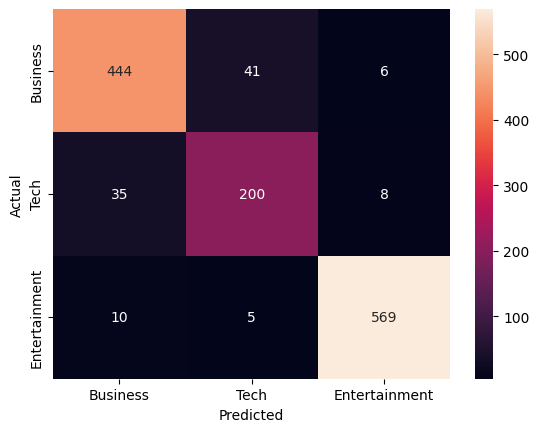

In [18]:
cf_matrix = confusion_matrix(y_test, predictions, labels=['business','tech','entertainment'])
sns.heatmap(cf_matrix, annot=True, fmt='', xticklabels=['Business','Tech','Entertainment'], yticklabels=['Business','Tech','Entertainment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classification Report


In [19]:
print('Classification Report:')
print (classification_report(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

     business       0.91      0.90      0.91       491
entertainment       0.98      0.97      0.98       584
         tech       0.81      0.82      0.82       243

     accuracy                           0.92      1318
    macro avg       0.90      0.90      0.90      1318
 weighted avg       0.92      0.92      0.92      1318

